In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 9iotn5sk


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-9iotn5sk:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                             | 0/5867 [00:00<?, ?it/s]

  0%|                                                                     | 1/5867 [00:00<51:24,  1.90it/s]

  0%|                                                                    | 10/5867 [00:00<04:46, 20.44it/s]

  0%|▏                                                                   | 19/5867 [00:00<02:42, 36.03it/s]

  0%|▎                                                                   | 28/5867 [00:00<02:00, 48.53it/s]

  1%|▍                                                                   | 37/5867 [00:00<01:40, 58.19it/s]

  1%|▌                                                                   | 46/5867 [00:01<01:28, 65.50it/s]

  1%|▋                                                                   | 55/5867 [00:01<01:21, 70.92it/s]

  1%|▋                                                                   | 64/5867 [00:01<01:17, 74.72it/s]

  1%|▊                                                                   | 73/5867 [00:01<01:14, 77.53it/s]

  1%|▉                                                                   | 82/5867 [00:01<01:12, 79.57it/s]

  2%|█                                                                   | 91/5867 [00:01<01:11, 81.00it/s]

  2%|█▏                                                                 | 100/5867 [00:01<01:10, 81.90it/s]

  2%|█▏                                                                 | 109/5867 [00:01<01:09, 82.63it/s]

  2%|█▎                                                                 | 118/5867 [00:01<01:09, 83.17it/s]

  2%|█▍                                                                 | 127/5867 [00:02<01:08, 83.52it/s]

  2%|█▌                                                                 | 136/5867 [00:02<01:08, 83.79it/s]

  2%|█▋                                                                 | 145/5867 [00:02<01:08, 83.97it/s]

  3%|█▊                                                                 | 154/5867 [00:02<01:07, 84.13it/s]

  3%|█▊                                                                 | 163/5867 [00:02<01:07, 84.15it/s]

  3%|█▉                                                                 | 172/5867 [00:02<01:07, 84.27it/s]

  3%|██                                                                 | 181/5867 [00:02<01:07, 84.32it/s]

  3%|██▏                                                                | 190/5867 [00:02<01:07, 84.31it/s]

  3%|██▎                                                                | 199/5867 [00:02<01:07, 84.32it/s]

  4%|██▍                                                                | 208/5867 [00:02<01:07, 84.41it/s]

  4%|██▍                                                                | 217/5867 [00:03<01:06, 84.38it/s]

  4%|██▌                                                                | 226/5867 [00:03<01:06, 84.39it/s]

  4%|██▋                                                                | 235/5867 [00:03<01:06, 84.40it/s]

  4%|██▊                                                                | 244/5867 [00:03<01:06, 84.44it/s]

  4%|██▉                                                                | 253/5867 [00:03<01:06, 84.32it/s]

  4%|██▉                                                                | 262/5867 [00:03<01:06, 84.27it/s]

  5%|███                                                                | 271/5867 [00:03<01:06, 84.24it/s]

  5%|███▏                                                               | 280/5867 [00:03<01:06, 84.19it/s]

  5%|███▎                                                               | 289/5867 [00:03<01:06, 84.18it/s]

  5%|███▍                                                               | 298/5867 [00:04<01:06, 84.05it/s]

  5%|███▌                                                               | 307/5867 [00:04<01:06, 84.03it/s]

  5%|███▌                                                               | 316/5867 [00:04<01:06, 84.06it/s]

  6%|███▋                                                               | 325/5867 [00:04<01:06, 83.97it/s]

  6%|███▊                                                               | 334/5867 [00:04<01:05, 84.04it/s]

  6%|███▉                                                               | 343/5867 [00:04<01:05, 84.18it/s]

  6%|████                                                               | 352/5867 [00:04<01:05, 84.21it/s]

  6%|████                                                               | 361/5867 [00:04<01:05, 84.24it/s]

  6%|████▏                                                              | 370/5867 [00:04<01:05, 84.31it/s]

  6%|████▎                                                              | 379/5867 [00:05<01:05, 84.33it/s]

  7%|████▍                                                              | 388/5867 [00:05<01:04, 84.41it/s]

  7%|████▌                                                              | 397/5867 [00:05<01:04, 84.48it/s]

  7%|████▋                                                              | 406/5867 [00:05<01:04, 84.45it/s]

  7%|████▋                                                              | 415/5867 [00:05<01:04, 84.49it/s]

  7%|████▊                                                              | 424/5867 [00:05<01:04, 84.54it/s]

  7%|████▉                                                              | 433/5867 [00:05<01:04, 84.54it/s]

  8%|█████                                                              | 442/5867 [00:05<01:04, 84.52it/s]

  8%|█████▏                                                             | 451/5867 [00:05<01:04, 84.56it/s]

  8%|█████▎                                                             | 460/5867 [00:05<01:03, 84.55it/s]

  8%|█████▎                                                             | 469/5867 [00:06<01:03, 84.52it/s]

  8%|█████▍                                                             | 478/5867 [00:06<01:03, 84.55it/s]

  8%|█████▌                                                             | 487/5867 [00:06<01:03, 84.56it/s]

  8%|█████▋                                                             | 496/5867 [00:06<01:03, 84.54it/s]

  9%|█████▊                                                             | 505/5867 [00:06<01:03, 84.59it/s]

  9%|█████▊                                                             | 514/5867 [00:06<01:03, 84.50it/s]

  9%|█████▉                                                             | 523/5867 [00:06<01:03, 84.53it/s]

  9%|██████                                                             | 532/5867 [00:06<01:03, 84.57it/s]

  9%|██████▏                                                            | 541/5867 [00:06<01:03, 84.51it/s]

  9%|██████▎                                                            | 550/5867 [00:07<01:02, 84.50it/s]

 10%|██████▍                                                            | 559/5867 [00:07<01:02, 84.56it/s]

 10%|██████▍                                                            | 568/5867 [00:07<01:02, 84.56it/s]

 10%|██████▌                                                            | 577/5867 [00:07<01:03, 83.03it/s]

 10%|██████▋                                                            | 586/5867 [00:07<01:03, 83.43it/s]

 10%|██████▊                                                            | 595/5867 [00:07<01:02, 83.70it/s]

 10%|██████▉                                                            | 604/5867 [00:07<01:02, 83.95it/s]

 10%|███████                                                            | 613/5867 [00:07<01:02, 84.11it/s]

 11%|███████                                                            | 622/5867 [00:07<01:02, 84.27it/s]

 11%|███████▏                                                           | 631/5867 [00:07<01:02, 84.26it/s]

 11%|███████▎                                                           | 640/5867 [00:08<01:01, 84.37it/s]

 11%|███████▍                                                           | 649/5867 [00:08<01:01, 84.34it/s]

 11%|███████▌                                                           | 658/5867 [00:08<01:01, 84.45it/s]

 11%|███████▌                                                           | 667/5867 [00:08<01:01, 84.49it/s]

 12%|███████▋                                                           | 676/5867 [00:08<01:01, 84.50it/s]

 12%|███████▊                                                           | 685/5867 [00:08<01:13, 70.53it/s]

 12%|███████▉                                                           | 694/5867 [00:08<01:09, 74.26it/s]

 12%|████████                                                           | 703/5867 [00:08<01:06, 77.11it/s]

 12%|████████▏                                                          | 712/5867 [00:09<01:05, 79.23it/s]

 12%|████████▏                                                          | 721/5867 [00:09<01:03, 80.72it/s]

 12%|████████▎                                                          | 730/5867 [00:09<01:02, 81.74it/s]

 13%|████████▍                                                          | 739/5867 [00:09<01:02, 82.59it/s]

 13%|████████▌                                                          | 748/5867 [00:09<01:01, 83.20it/s]

 13%|████████▋                                                          | 757/5867 [00:09<01:01, 83.64it/s]

 13%|████████▋                                                          | 766/5867 [00:09<01:00, 83.88it/s]

 13%|████████▊                                                          | 775/5867 [00:09<01:00, 84.06it/s]

 13%|████████▉                                                          | 784/5867 [00:09<01:00, 84.25it/s]

 14%|█████████                                                          | 793/5867 [00:09<01:00, 84.36it/s]

 14%|█████████▏                                                         | 802/5867 [00:10<01:00, 84.38it/s]

 14%|█████████▎                                                         | 811/5867 [00:10<00:59, 84.48it/s]

 14%|█████████▎                                                         | 820/5867 [00:10<00:59, 84.42it/s]

 14%|█████████▍                                                         | 829/5867 [00:10<00:59, 84.58it/s]

 14%|█████████▌                                                         | 838/5867 [00:10<00:59, 84.59it/s]

 14%|█████████▋                                                         | 847/5867 [00:10<00:59, 84.63it/s]

 15%|█████████▊                                                         | 856/5867 [00:10<00:59, 84.58it/s]

 15%|█████████▉                                                         | 865/5867 [00:10<00:59, 84.63it/s]

 15%|█████████▉                                                         | 874/5867 [00:10<00:58, 84.64it/s]

 15%|██████████                                                         | 883/5867 [00:11<00:58, 84.61it/s]

 15%|██████████▏                                                        | 892/5867 [00:11<00:58, 84.65it/s]

 15%|██████████▎                                                        | 901/5867 [00:11<00:58, 84.66it/s]

 16%|██████████▍                                                        | 910/5867 [00:11<00:58, 84.67it/s]

 16%|██████████▍                                                        | 919/5867 [00:11<00:58, 84.61it/s]

 16%|██████████▌                                                        | 928/5867 [00:11<00:58, 84.13it/s]

 16%|██████████▋                                                        | 937/5867 [00:11<00:58, 83.87it/s]

 16%|██████████▊                                                        | 946/5867 [00:11<00:58, 83.67it/s]

 16%|██████████▉                                                        | 955/5867 [00:11<00:58, 83.49it/s]

 16%|███████████                                                        | 964/5867 [00:12<00:58, 83.34it/s]

 17%|███████████                                                        | 973/5867 [00:12<00:58, 83.18it/s]

 17%|███████████▏                                                       | 982/5867 [00:12<00:58, 83.03it/s]

 17%|███████████▎                                                       | 991/5867 [00:12<00:58, 82.96it/s]

 17%|███████████▏                                                      | 1000/5867 [00:12<00:58, 82.86it/s]

 17%|███████████▎                                                      | 1009/5867 [00:12<00:58, 82.90it/s]

 17%|███████████▍                                                      | 1018/5867 [00:12<00:58, 82.96it/s]

 18%|███████████▌                                                      | 1027/5867 [00:12<00:58, 83.05it/s]

 18%|███████████▋                                                      | 1036/5867 [00:12<00:58, 83.06it/s]

 18%|███████████▊                                                      | 1045/5867 [00:12<00:58, 83.13it/s]

 18%|███████████▊                                                      | 1054/5867 [00:13<00:57, 83.12it/s]

 18%|███████████▉                                                      | 1063/5867 [00:13<00:57, 83.13it/s]

 18%|████████████                                                      | 1072/5867 [00:13<00:57, 83.16it/s]

 18%|████████████▏                                                     | 1081/5867 [00:13<00:57, 83.17it/s]

 19%|████████████▎                                                     | 1090/5867 [00:13<00:57, 83.22it/s]

 19%|████████████▎                                                     | 1099/5867 [00:13<00:57, 83.22it/s]

 19%|████████████▍                                                     | 1108/5867 [00:13<00:57, 83.25it/s]

 19%|████████████▌                                                     | 1117/5867 [00:13<00:57, 83.21it/s]

 19%|████████████▋                                                     | 1126/5867 [00:13<00:56, 83.19it/s]

 19%|████████████▊                                                     | 1135/5867 [00:14<00:56, 83.19it/s]

 19%|████████████▊                                                     | 1144/5867 [00:14<00:56, 83.21it/s]

 20%|████████████▉                                                     | 1153/5867 [00:14<00:56, 83.19it/s]

 20%|█████████████                                                     | 1162/5867 [00:14<00:56, 83.20it/s]

 20%|█████████████▏                                                    | 1171/5867 [00:14<00:56, 83.11it/s]

 20%|█████████████▎                                                    | 1180/5867 [00:14<00:56, 83.17it/s]

 20%|█████████████▍                                                    | 1189/5867 [00:14<00:56, 83.17it/s]

 20%|█████████████▍                                                    | 1198/5867 [00:14<00:56, 83.16it/s]

 21%|█████████████▌                                                    | 1207/5867 [00:14<00:56, 83.18it/s]

 21%|█████████████▋                                                    | 1216/5867 [00:15<00:55, 83.16it/s]

 21%|█████████████▊                                                    | 1225/5867 [00:15<00:55, 83.18it/s]

 21%|█████████████▉                                                    | 1234/5867 [00:15<00:55, 83.16it/s]

 21%|█████████████▉                                                    | 1243/5867 [00:15<00:55, 83.18it/s]

 21%|██████████████                                                    | 1252/5867 [00:15<00:55, 83.18it/s]

 21%|██████████████▏                                                   | 1261/5867 [00:15<00:55, 83.19it/s]

 22%|██████████████▎                                                   | 1270/5867 [00:15<00:55, 83.19it/s]

 22%|██████████████▍                                                   | 1279/5867 [00:15<00:55, 83.18it/s]

 22%|██████████████▍                                                   | 1288/5867 [00:15<00:55, 83.17it/s]

 22%|██████████████▌                                                   | 1297/5867 [00:16<00:54, 83.15it/s]

 22%|██████████████▋                                                   | 1306/5867 [00:16<00:54, 83.17it/s]

 22%|██████████████▊                                                   | 1315/5867 [00:16<00:54, 83.09it/s]

 23%|██████████████▉                                                   | 1324/5867 [00:16<00:54, 83.08it/s]

 23%|██████████████▉                                                   | 1333/5867 [00:16<00:54, 83.08it/s]

 23%|███████████████                                                   | 1342/5867 [00:16<00:54, 83.10it/s]

 23%|███████████████▏                                                  | 1351/5867 [00:16<00:54, 83.14it/s]

 23%|███████████████▎                                                  | 1360/5867 [00:16<00:54, 83.16it/s]

 23%|███████████████▍                                                  | 1369/5867 [00:16<00:54, 83.16it/s]

 23%|███████████████▌                                                  | 1378/5867 [00:16<00:53, 83.14it/s]

 24%|███████████████▌                                                  | 1387/5867 [00:17<00:53, 83.13it/s]

 24%|███████████████▋                                                  | 1396/5867 [00:17<00:53, 83.14it/s]

 24%|███████████████▊                                                  | 1405/5867 [00:17<00:53, 83.15it/s]

 24%|███████████████▉                                                  | 1414/5867 [00:17<00:53, 83.13it/s]

 24%|████████████████                                                  | 1423/5867 [00:17<00:53, 83.11it/s]

 24%|████████████████                                                  | 1432/5867 [00:17<00:53, 83.12it/s]

 25%|████████████████▏                                                 | 1441/5867 [00:17<00:53, 83.11it/s]

 25%|████████████████▎                                                 | 1450/5867 [00:17<00:53, 83.09it/s]

 25%|████████████████▍                                                 | 1459/5867 [00:17<00:53, 83.11it/s]

 25%|████████████████▌                                                 | 1468/5867 [00:18<00:52, 83.17it/s]

 25%|████████████████▌                                                 | 1477/5867 [00:18<00:52, 83.14it/s]

 25%|████████████████▋                                                 | 1486/5867 [00:18<00:52, 83.07it/s]

 25%|████████████████▊                                                 | 1495/5867 [00:18<00:52, 83.13it/s]

 26%|████████████████▉                                                 | 1504/5867 [00:18<00:52, 83.19it/s]

 26%|█████████████████                                                 | 1513/5867 [00:18<00:52, 83.07it/s]

 26%|█████████████████                                                 | 1522/5867 [00:18<00:52, 83.14it/s]

 26%|█████████████████▏                                                | 1531/5867 [00:18<00:52, 83.17it/s]

 26%|█████████████████▎                                                | 1540/5867 [00:18<00:51, 83.21it/s]

 26%|█████████████████▍                                                | 1549/5867 [00:19<00:51, 83.23it/s]

 27%|█████████████████▌                                                | 1558/5867 [00:19<00:51, 83.22it/s]

 27%|█████████████████▋                                                | 1567/5867 [00:19<00:51, 83.20it/s]

 27%|█████████████████▋                                                | 1576/5867 [00:19<00:51, 83.21it/s]

 27%|█████████████████▊                                                | 1585/5867 [00:19<00:51, 83.20it/s]

 27%|█████████████████▉                                                | 1594/5867 [00:19<00:51, 83.19it/s]

 27%|██████████████████                                                | 1603/5867 [00:19<00:51, 83.19it/s]

 27%|██████████████████▏                                               | 1612/5867 [00:19<00:51, 83.15it/s]

 28%|██████████████████▏                                               | 1621/5867 [00:19<00:51, 83.16it/s]

 28%|██████████████████▎                                               | 1630/5867 [00:20<00:50, 83.18it/s]

 28%|██████████████████▍                                               | 1639/5867 [00:20<00:50, 83.18it/s]

 28%|██████████████████▌                                               | 1648/5867 [00:20<00:50, 83.20it/s]

 28%|██████████████████▋                                               | 1657/5867 [00:20<00:50, 83.16it/s]

 28%|██████████████████▋                                               | 1666/5867 [00:20<00:50, 82.87it/s]

 29%|██████████████████▊                                               | 1675/5867 [00:20<00:50, 82.72it/s]

 29%|██████████████████▉                                               | 1684/5867 [00:20<00:50, 82.81it/s]

 29%|███████████████████                                               | 1693/5867 [00:20<00:50, 82.95it/s]

 29%|███████████████████▏                                              | 1702/5867 [00:20<00:50, 83.00it/s]

 29%|███████████████████▏                                              | 1711/5867 [00:21<00:50, 83.05it/s]

 29%|███████████████████▎                                              | 1720/5867 [00:21<00:49, 83.08it/s]

 29%|███████████████████▍                                              | 1729/5867 [00:21<00:49, 83.11it/s]

 30%|███████████████████▌                                              | 1738/5867 [00:21<00:49, 83.14it/s]

 30%|███████████████████▋                                              | 1747/5867 [00:21<00:49, 83.16it/s]

 30%|███████████████████▊                                              | 1756/5867 [00:21<00:49, 83.16it/s]

 30%|███████████████████▊                                              | 1765/5867 [00:21<00:49, 83.15it/s]

 30%|███████████████████▉                                              | 1774/5867 [00:21<00:49, 83.15it/s]

 30%|████████████████████                                              | 1783/5867 [00:21<00:49, 83.17it/s]

 31%|████████████████████▏                                             | 1792/5867 [00:21<00:49, 83.11it/s]

 31%|████████████████████▎                                             | 1801/5867 [00:22<00:48, 83.11it/s]

 31%|████████████████████▎                                             | 1810/5867 [00:22<00:48, 83.11it/s]

 31%|████████████████████▍                                             | 1819/5867 [00:22<00:48, 83.13it/s]

 31%|████████████████████▌                                             | 1828/5867 [00:22<00:48, 83.15it/s]

 31%|████████████████████▋                                             | 1837/5867 [00:22<00:48, 83.14it/s]

 31%|████████████████████▊                                             | 1846/5867 [00:22<00:48, 83.14it/s]

 32%|████████████████████▊                                             | 1855/5867 [00:22<00:48, 83.16it/s]

 32%|████████████████████▉                                             | 1864/5867 [00:22<00:48, 83.19it/s]

 32%|█████████████████████                                             | 1873/5867 [00:22<00:48, 82.75it/s]

 32%|█████████████████████▏                                            | 1882/5867 [00:23<00:47, 83.40it/s]

 32%|█████████████████████▎                                            | 1891/5867 [00:23<00:47, 83.86it/s]

 32%|█████████████████████▎                                            | 1900/5867 [00:23<00:47, 84.16it/s]

 33%|█████████████████████▍                                            | 1909/5867 [00:23<00:46, 84.44it/s]

 33%|█████████████████████▌                                            | 1918/5867 [00:23<00:46, 84.48it/s]

 33%|█████████████████████▋                                            | 1927/5867 [00:23<00:46, 84.52it/s]

 33%|█████████████████████▊                                            | 1936/5867 [00:23<00:46, 84.58it/s]

 33%|█████████████████████▉                                            | 1945/5867 [00:23<00:46, 84.59it/s]

 33%|█████████████████████▉                                            | 1954/5867 [00:23<00:46, 84.57it/s]

 33%|██████████████████████                                            | 1963/5867 [00:24<00:46, 84.59it/s]

 34%|██████████████████████▏                                           | 1972/5867 [00:24<00:46, 84.62it/s]

 34%|██████████████████████▎                                           | 1981/5867 [00:24<00:45, 84.60it/s]

 34%|██████████████████████▍                                           | 1990/5867 [00:24<00:45, 84.63it/s]

 34%|██████████████████████▍                                           | 1999/5867 [00:24<00:45, 84.63it/s]

 34%|██████████████████████▌                                           | 2008/5867 [00:24<00:45, 84.66it/s]

 34%|██████████████████████▋                                           | 2017/5867 [00:24<00:45, 84.62it/s]

 35%|██████████████████████▊                                           | 2026/5867 [00:24<00:45, 84.67it/s]

 35%|██████████████████████▉                                           | 2035/5867 [00:24<00:45, 84.73it/s]

 35%|██████████████████████▉                                           | 2044/5867 [00:24<00:45, 84.67it/s]

 35%|███████████████████████                                           | 2053/5867 [00:25<00:45, 84.68it/s]

 35%|███████████████████████▏                                          | 2062/5867 [00:25<00:44, 84.70it/s]

 35%|███████████████████████▎                                          | 2071/5867 [00:25<00:44, 84.76it/s]

 35%|███████████████████████▍                                          | 2080/5867 [00:25<00:44, 84.71it/s]

 36%|███████████████████████▍                                          | 2089/5867 [00:25<00:44, 84.79it/s]

 36%|███████████████████████▌                                          | 2098/5867 [00:25<00:44, 84.85it/s]

 36%|███████████████████████▋                                          | 2107/5867 [00:25<00:44, 84.67it/s]

 36%|███████████████████████▊                                          | 2116/5867 [00:25<00:44, 84.39it/s]

 36%|███████████████████████▉                                          | 2125/5867 [00:25<00:44, 84.12it/s]

 36%|████████████████████████                                          | 2134/5867 [00:26<00:44, 83.87it/s]

 37%|████████████████████████                                          | 2143/5867 [00:26<00:44, 83.75it/s]

 37%|████████████████████████▏                                         | 2152/5867 [00:26<00:44, 83.67it/s]

 37%|████████████████████████▎                                         | 2161/5867 [00:26<00:44, 83.59it/s]

 37%|████████████████████████▍                                         | 2170/5867 [00:26<00:44, 83.54it/s]

 37%|████████████████████████▌                                         | 2179/5867 [00:26<00:44, 83.53it/s]

 37%|████████████████████████▌                                         | 2188/5867 [00:26<00:44, 83.51it/s]

 37%|████████████████████████▋                                         | 2197/5867 [00:26<00:43, 83.46it/s]

 38%|████████████████████████▊                                         | 2206/5867 [00:26<00:43, 83.38it/s]

 38%|████████████████████████▉                                         | 2215/5867 [00:27<00:43, 83.35it/s]

 38%|█████████████████████████                                         | 2224/5867 [00:27<00:43, 83.33it/s]

 38%|█████████████████████████                                         | 2233/5867 [00:27<00:43, 83.30it/s]

 38%|█████████████████████████▏                                        | 2242/5867 [00:27<00:43, 83.27it/s]

 38%|█████████████████████████▎                                        | 2251/5867 [00:27<00:43, 83.24it/s]

 39%|█████████████████████████▍                                        | 2260/5867 [00:27<00:43, 83.27it/s]

 39%|█████████████████████████▌                                        | 2269/5867 [00:27<00:43, 83.22it/s]

 39%|█████████████████████████▋                                        | 2278/5867 [00:27<00:43, 83.24it/s]

 39%|█████████████████████████▋                                        | 2287/5867 [00:27<00:43, 83.24it/s]

 39%|█████████████████████████▊                                        | 2296/5867 [00:27<00:42, 83.19it/s]

 39%|█████████████████████████▉                                        | 2305/5867 [00:28<00:42, 83.19it/s]

 39%|██████████████████████████                                        | 2314/5867 [00:28<00:42, 83.19it/s]

 40%|██████████████████████████▏                                       | 2323/5867 [00:28<00:42, 83.21it/s]

 40%|██████████████████████████▏                                       | 2332/5867 [00:28<00:42, 83.18it/s]

 40%|██████████████████████████▎                                       | 2341/5867 [00:28<00:42, 83.21it/s]

 40%|██████████████████████████▍                                       | 2350/5867 [00:28<00:42, 83.20it/s]

 40%|██████████████████████████▌                                       | 2359/5867 [00:28<00:42, 83.21it/s]

 40%|██████████████████████████▋                                       | 2368/5867 [00:28<00:42, 83.23it/s]

 41%|██████████████████████████▋                                       | 2377/5867 [00:28<00:41, 83.21it/s]

 41%|██████████████████████████▊                                       | 2386/5867 [00:29<00:41, 83.20it/s]

 41%|██████████████████████████▉                                       | 2395/5867 [00:29<00:41, 83.21it/s]

 41%|███████████████████████████                                       | 2404/5867 [00:29<00:41, 83.28it/s]

 41%|███████████████████████████▏                                      | 2413/5867 [00:29<00:41, 83.31it/s]

 41%|███████████████████████████▏                                      | 2422/5867 [00:29<00:41, 83.34it/s]

 41%|███████████████████████████▎                                      | 2431/5867 [00:29<00:41, 83.36it/s]

 42%|███████████████████████████▍                                      | 2440/5867 [00:29<00:41, 83.38it/s]

 42%|███████████████████████████▌                                      | 2449/5867 [00:29<00:40, 83.38it/s]

 42%|███████████████████████████▋                                      | 2458/5867 [00:29<00:40, 83.39it/s]

 42%|███████████████████████████▊                                      | 2467/5867 [00:30<00:40, 83.37it/s]

 42%|███████████████████████████▊                                      | 2476/5867 [00:30<00:40, 83.18it/s]

 42%|███████████████████████████▉                                      | 2485/5867 [00:30<00:40, 83.16it/s]

 43%|████████████████████████████                                      | 2494/5867 [00:30<00:40, 83.18it/s]

 43%|████████████████████████████▏                                     | 2503/5867 [00:30<00:40, 83.26it/s]

 43%|████████████████████████████▎                                     | 2512/5867 [00:30<00:40, 83.32it/s]

 43%|████████████████████████████▎                                     | 2521/5867 [00:30<00:40, 83.31it/s]

 43%|████████████████████████████▍                                     | 2530/5867 [00:30<00:40, 83.27it/s]

 43%|████████████████████████████▌                                     | 2539/5867 [00:30<00:40, 83.19it/s]

 43%|████████████████████████████▋                                     | 2548/5867 [00:31<00:39, 83.18it/s]

 44%|████████████████████████████▊                                     | 2557/5867 [00:31<00:39, 83.15it/s]

 44%|████████████████████████████▊                                     | 2566/5867 [00:31<00:39, 83.13it/s]

 44%|████████████████████████████▉                                     | 2575/5867 [00:31<00:39, 83.10it/s]

 44%|█████████████████████████████                                     | 2584/5867 [00:31<00:39, 83.13it/s]

 44%|█████████████████████████████▏                                    | 2593/5867 [00:31<00:39, 83.10it/s]

 44%|█████████████████████████████▎                                    | 2602/5867 [00:31<00:39, 83.07it/s]

 45%|█████████████████████████████▎                                    | 2611/5867 [00:31<00:39, 83.08it/s]

 45%|█████████████████████████████▍                                    | 2620/5867 [00:31<00:39, 83.10it/s]

 45%|█████████████████████████████▌                                    | 2629/5867 [00:31<00:38, 83.12it/s]

 45%|█████████████████████████████▋                                    | 2638/5867 [00:32<00:38, 83.12it/s]

 45%|█████████████████████████████▊                                    | 2647/5867 [00:32<00:38, 83.13it/s]

 45%|█████████████████████████████▉                                    | 2656/5867 [00:32<00:38, 83.12it/s]

 45%|█████████████████████████████▉                                    | 2665/5867 [00:32<00:38, 83.10it/s]

 46%|██████████████████████████████                                    | 2674/5867 [00:32<00:38, 83.08it/s]

 46%|██████████████████████████████▏                                   | 2683/5867 [00:32<00:38, 83.11it/s]

 46%|██████████████████████████████▎                                   | 2692/5867 [00:32<00:38, 83.17it/s]

 46%|██████████████████████████████▍                                   | 2701/5867 [00:32<00:38, 83.19it/s]

 46%|██████████████████████████████▍                                   | 2710/5867 [00:32<00:37, 83.23it/s]

 46%|██████████████████████████████▌                                   | 2719/5867 [00:33<00:37, 83.29it/s]

 46%|██████████████████████████████▋                                   | 2728/5867 [00:33<00:37, 83.32it/s]

 47%|██████████████████████████████▊                                   | 2737/5867 [00:33<00:37, 83.37it/s]

 47%|██████████████████████████████▉                                   | 2746/5867 [00:33<00:37, 83.37it/s]

 47%|██████████████████████████████▉                                   | 2755/5867 [00:33<00:37, 83.34it/s]

 47%|███████████████████████████████                                   | 2764/5867 [00:33<00:37, 83.28it/s]

 47%|███████████████████████████████▏                                  | 2773/5867 [00:33<00:37, 83.27it/s]

 47%|███████████████████████████████▎                                  | 2782/5867 [00:33<00:37, 83.29it/s]

 48%|███████████████████████████████▍                                  | 2791/5867 [00:33<00:36, 83.31it/s]

 48%|███████████████████████████████▍                                  | 2800/5867 [00:34<00:36, 83.33it/s]

 48%|███████████████████████████████▌                                  | 2809/5867 [00:34<00:36, 83.30it/s]

 48%|███████████████████████████████▋                                  | 2818/5867 [00:34<00:36, 83.25it/s]

 48%|███████████████████████████████▊                                  | 2827/5867 [00:34<00:36, 83.23it/s]

 48%|███████████████████████████████▉                                  | 2836/5867 [00:34<00:36, 83.23it/s]

 48%|████████████████████████████████                                  | 2845/5867 [00:34<00:36, 83.24it/s]

 49%|████████████████████████████████                                  | 2854/5867 [00:34<00:36, 83.28it/s]

 49%|████████████████████████████████▏                                 | 2863/5867 [00:34<00:36, 83.30it/s]

 49%|████████████████████████████████▎                                 | 2872/5867 [00:34<00:35, 83.26it/s]

 49%|████████████████████████████████▍                                 | 2881/5867 [00:35<00:35, 83.24it/s]

 49%|████████████████████████████████▌                                 | 2890/5867 [00:35<00:35, 83.22it/s]

 49%|████████████████████████████████▌                                 | 2899/5867 [00:35<00:35, 83.10it/s]

 50%|████████████████████████████████▋                                 | 2908/5867 [00:35<00:35, 83.02it/s]

 50%|████████████████████████████████▊                                 | 2917/5867 [00:35<00:35, 82.93it/s]

 50%|████████████████████████████████▉                                 | 2926/5867 [00:35<00:35, 82.88it/s]

 50%|█████████████████████████████████                                 | 2935/5867 [00:35<00:35, 82.87it/s]

 50%|█████████████████████████████████                                 | 2944/5867 [00:35<00:35, 82.82it/s]

 50%|█████████████████████████████████▏                                | 2953/5867 [00:35<00:35, 82.73it/s]

 50%|█████████████████████████████████▎                                | 2962/5867 [00:35<00:35, 82.71it/s]

 51%|█████████████████████████████████▍                                | 2971/5867 [00:36<00:35, 82.44it/s]

 51%|█████████████████████████████████▌                                | 2980/5867 [00:36<00:35, 82.36it/s]

 51%|█████████████████████████████████▌                                | 2989/5867 [00:36<00:35, 82.22it/s]

 51%|█████████████████████████████████▋                                | 2998/5867 [00:36<00:34, 81.99it/s]

 51%|█████████████████████████████████▊                                | 3007/5867 [00:36<00:34, 81.84it/s]

 51%|█████████████████████████████████▉                                | 3016/5867 [00:36<00:34, 82.01it/s]

 52%|██████████████████████████████████                                | 3025/5867 [00:36<00:34, 82.19it/s]

 52%|██████████████████████████████████▏                               | 3034/5867 [00:36<00:34, 82.45it/s]

 52%|██████████████████████████████████▏                               | 3043/5867 [00:36<00:34, 82.65it/s]

 52%|██████████████████████████████████▎                               | 3052/5867 [00:37<00:33, 82.83it/s]

 52%|██████████████████████████████████▍                               | 3061/5867 [00:37<00:33, 82.80it/s]

 52%|██████████████████████████████████▌                               | 3070/5867 [00:37<00:33, 82.71it/s]

 52%|██████████████████████████████████▋                               | 3079/5867 [00:37<00:33, 82.83it/s]

 53%|██████████████████████████████████▋                               | 3088/5867 [00:37<00:33, 82.80it/s]

 53%|██████████████████████████████████▊                               | 3097/5867 [00:37<00:33, 82.93it/s]

 53%|██████████████████████████████████▉                               | 3106/5867 [00:37<00:33, 83.02it/s]

 53%|███████████████████████████████████                               | 3115/5867 [00:37<00:33, 83.00it/s]

 53%|███████████████████████████████████▏                              | 3124/5867 [00:37<00:33, 82.95it/s]

 53%|███████████████████████████████████▏                              | 3133/5867 [00:38<00:33, 82.77it/s]

 54%|███████████████████████████████████▎                              | 3142/5867 [00:38<00:32, 82.92it/s]

 54%|███████████████████████████████████▍                              | 3151/5867 [00:38<00:32, 83.02it/s]

 54%|███████████████████████████████████▌                              | 3160/5867 [00:38<00:32, 83.07it/s]

 54%|███████████████████████████████████▋                              | 3169/5867 [00:38<00:32, 83.18it/s]

 54%|███████████████████████████████████▊                              | 3178/5867 [00:38<00:32, 83.22it/s]

 54%|███████████████████████████████████▊                              | 3187/5867 [00:38<00:32, 83.12it/s]

 54%|███████████████████████████████████▉                              | 3196/5867 [00:38<00:32, 82.98it/s]

 55%|████████████████████████████████████                              | 3205/5867 [00:38<00:32, 82.92it/s]

 55%|████████████████████████████████████▏                             | 3214/5867 [00:39<00:31, 83.10it/s]

 55%|████████████████████████████████████▎                             | 3223/5867 [00:39<00:31, 83.20it/s]

 55%|████████████████████████████████████▎                             | 3232/5867 [00:39<00:31, 83.24it/s]

 55%|████████████████████████████████████▍                             | 3241/5867 [00:39<00:31, 83.28it/s]

 55%|████████████████████████████████████▌                             | 3250/5867 [00:39<00:31, 83.25it/s]

 56%|████████████████████████████████████▋                             | 3259/5867 [00:39<00:31, 83.14it/s]

 56%|████████████████████████████████████▊                             | 3268/5867 [00:39<00:31, 83.01it/s]

 56%|████████████████████████████████████▊                             | 3277/5867 [00:39<00:31, 82.88it/s]

 56%|████████████████████████████████████▉                             | 3286/5867 [00:39<00:31, 82.96it/s]

 56%|█████████████████████████████████████                             | 3295/5867 [00:40<00:30, 83.10it/s]

 56%|█████████████████████████████████████▏                            | 3304/5867 [00:40<00:30, 83.16it/s]

 56%|█████████████████████████████████████▎                            | 3313/5867 [00:40<00:30, 83.10it/s]

 57%|█████████████████████████████████████▎                            | 3322/5867 [00:40<00:30, 83.17it/s]

 57%|█████████████████████████████████████▍                            | 3331/5867 [00:40<00:30, 83.15it/s]

 57%|█████████████████████████████████████▌                            | 3340/5867 [00:40<00:30, 83.18it/s]

 57%|█████████████████████████████████████▋                            | 3349/5867 [00:40<00:30, 83.18it/s]

 57%|█████████████████████████████████████▊                            | 3358/5867 [00:40<00:30, 83.22it/s]

 57%|█████████████████████████████████████▉                            | 3367/5867 [00:40<00:30, 83.19it/s]

 58%|█████████████████████████████████████▉                            | 3376/5867 [00:40<00:30, 82.53it/s]

 58%|██████████████████████████████████████                            | 3385/5867 [00:41<00:29, 82.97it/s]

 58%|██████████████████████████████████████▏                           | 3394/5867 [00:41<00:29, 83.14it/s]

 58%|██████████████████████████████████████▎                           | 3403/5867 [00:41<00:29, 83.20it/s]

 58%|██████████████████████████████████████▍                           | 3412/5867 [00:41<00:29, 83.24it/s]

 58%|██████████████████████████████████████▍                           | 3421/5867 [00:41<00:29, 83.20it/s]

 58%|██████████████████████████████████████▌                           | 3430/5867 [00:41<00:29, 83.24it/s]

 59%|██████████████████████████████████████▋                           | 3439/5867 [00:41<00:29, 83.25it/s]

 59%|██████████████████████████████████████▊                           | 3448/5867 [00:41<00:29, 83.29it/s]

 59%|██████████████████████████████████████▉                           | 3457/5867 [00:41<00:28, 83.33it/s]

 59%|██████████████████████████████████████▉                           | 3466/5867 [00:42<00:28, 83.37it/s]

 59%|███████████████████████████████████████                           | 3475/5867 [00:42<00:28, 83.35it/s]

 59%|███████████████████████████████████████▏                          | 3484/5867 [00:42<00:28, 83.35it/s]

 60%|███████████████████████████████████████▎                          | 3493/5867 [00:42<00:28, 83.38it/s]

 60%|███████████████████████████████████████▍                          | 3502/5867 [00:42<00:28, 83.42it/s]

 60%|███████████████████████████████████████▍                          | 3511/5867 [00:42<00:28, 83.43it/s]

 60%|███████████████████████████████████████▌                          | 3520/5867 [00:42<00:28, 83.46it/s]

 60%|███████████████████████████████████████▋                          | 3529/5867 [00:42<00:28, 83.46it/s]

 60%|███████████████████████████████████████▊                          | 3538/5867 [00:42<00:27, 83.48it/s]

 60%|███████████████████████████████████████▉                          | 3547/5867 [00:43<00:27, 83.44it/s]

 61%|████████████████████████████████████████                          | 3556/5867 [00:43<00:27, 83.48it/s]

 61%|████████████████████████████████████████                          | 3565/5867 [00:43<00:27, 83.49it/s]

 61%|████████████████████████████████████████▏                         | 3574/5867 [00:43<00:27, 83.50it/s]

 61%|████████████████████████████████████████▎                         | 3583/5867 [00:43<00:27, 83.46it/s]

 61%|████████████████████████████████████████▍                         | 3592/5867 [00:43<00:27, 83.44it/s]

 61%|████████████████████████████████████████▌                         | 3601/5867 [00:43<00:27, 83.44it/s]

 62%|████████████████████████████████████████▌                         | 3610/5867 [00:43<00:27, 83.44it/s]

 62%|████████████████████████████████████████▋                         | 3619/5867 [00:43<00:26, 83.44it/s]

 62%|████████████████████████████████████████▊                         | 3628/5867 [00:44<00:26, 83.47it/s]

 62%|████████████████████████████████████████▉                         | 3637/5867 [00:44<00:26, 83.46it/s]

 62%|█████████████████████████████████████████                         | 3646/5867 [00:44<00:26, 83.40it/s]

 62%|█████████████████████████████████████████                         | 3655/5867 [00:44<00:26, 83.36it/s]

 62%|█████████████████████████████████████████▏                        | 3664/5867 [00:44<00:26, 83.41it/s]

 63%|█████████████████████████████████████████▎                        | 3673/5867 [00:44<00:26, 83.43it/s]

 63%|█████████████████████████████████████████▍                        | 3682/5867 [00:44<00:26, 83.45it/s]

 63%|█████████████████████████████████████████▌                        | 3691/5867 [00:44<00:26, 83.49it/s]

 63%|█████████████████████████████████████████▌                        | 3700/5867 [00:44<00:25, 83.52it/s]

 63%|█████████████████████████████████████████▋                        | 3709/5867 [00:44<00:25, 83.50it/s]

 63%|█████████████████████████████████████████▊                        | 3718/5867 [00:45<00:25, 83.49it/s]

 64%|█████████████████████████████████████████▉                        | 3727/5867 [00:45<00:25, 83.50it/s]

 64%|██████████████████████████████████████████                        | 3736/5867 [00:45<00:25, 83.53it/s]

 64%|██████████████████████████████████████████▏                       | 3745/5867 [00:45<00:25, 83.14it/s]

 64%|██████████████████████████████████████████▏                       | 3754/5867 [00:45<00:25, 83.05it/s]

 64%|██████████████████████████████████████████▎                       | 3763/5867 [00:45<00:25, 82.96it/s]

 64%|██████████████████████████████████████████▍                       | 3772/5867 [00:45<00:25, 82.89it/s]

 64%|██████████████████████████████████████████▌                       | 3781/5867 [00:45<00:25, 82.87it/s]

 65%|██████████████████████████████████████████▋                       | 3790/5867 [00:45<00:25, 83.00it/s]

 65%|██████████████████████████████████████████▋                       | 3799/5867 [00:46<00:25, 82.57it/s]

 65%|██████████████████████████████████████████▊                       | 3808/5867 [00:46<00:24, 83.05it/s]

 65%|██████████████████████████████████████████▉                       | 3817/5867 [00:46<00:24, 83.11it/s]

 65%|███████████████████████████████████████████                       | 3826/5867 [00:46<00:24, 83.22it/s]

 65%|███████████████████████████████████████████▏                      | 3835/5867 [00:46<00:24, 83.27it/s]

 66%|███████████████████████████████████████████▏                      | 3844/5867 [00:46<00:24, 83.31it/s]

 66%|███████████████████████████████████████████▎                      | 3853/5867 [00:46<00:24, 83.34it/s]

 66%|███████████████████████████████████████████▍                      | 3862/5867 [00:46<00:24, 83.33it/s]

 66%|███████████████████████████████████████████▌                      | 3871/5867 [00:46<00:23, 83.38it/s]

 66%|███████████████████████████████████████████▋                      | 3880/5867 [00:47<00:23, 83.38it/s]

 66%|███████████████████████████████████████████▋                      | 3889/5867 [00:47<00:23, 83.37it/s]

 66%|███████████████████████████████████████████▊                      | 3898/5867 [00:47<00:23, 83.44it/s]

 67%|███████████████████████████████████████████▉                      | 3907/5867 [00:47<00:23, 83.47it/s]

 67%|████████████████████████████████████████████                      | 3916/5867 [00:47<00:23, 83.46it/s]

 67%|████████████████████████████████████████████▏                     | 3925/5867 [00:47<00:23, 83.48it/s]

 67%|████████████████████████████████████████████▎                     | 3934/5867 [00:47<00:23, 83.45it/s]

 67%|████████████████████████████████████████████▎                     | 3943/5867 [00:47<00:23, 83.46it/s]

 67%|████████████████████████████████████████████▍                     | 3952/5867 [00:47<00:22, 83.40it/s]

 68%|████████████████████████████████████████████▌                     | 3961/5867 [00:48<00:22, 83.44it/s]

 68%|████████████████████████████████████████████▋                     | 3970/5867 [00:48<00:22, 83.49it/s]

 68%|████████████████████████████████████████████▊                     | 3979/5867 [00:48<00:22, 83.46it/s]

 68%|████████████████████████████████████████████▊                     | 3988/5867 [00:48<00:22, 83.49it/s]

 68%|████████████████████████████████████████████▉                     | 3997/5867 [00:48<00:22, 83.48it/s]

 68%|█████████████████████████████████████████████                     | 4006/5867 [00:48<00:22, 83.41it/s]

 68%|█████████████████████████████████████████████▏                    | 4015/5867 [00:48<00:22, 83.37it/s]

 69%|█████████████████████████████████████████████▎                    | 4024/5867 [00:48<00:22, 83.43it/s]

 69%|█████████████████████████████████████████████▎                    | 4033/5867 [00:48<00:21, 83.49it/s]

 69%|█████████████████████████████████████████████▍                    | 4042/5867 [00:48<00:21, 83.51it/s]

 69%|█████████████████████████████████████████████▌                    | 4051/5867 [00:49<00:21, 83.52it/s]

 69%|█████████████████████████████████████████████▋                    | 4060/5867 [00:49<00:21, 83.51it/s]

 69%|█████████████████████████████████████████████▊                    | 4069/5867 [00:49<00:21, 83.48it/s]

 70%|█████████████████████████████████████████████▊                    | 4078/5867 [00:49<00:21, 83.50it/s]

 70%|█████████████████████████████████████████████▉                    | 4087/5867 [00:49<00:21, 83.44it/s]

 70%|██████████████████████████████████████████████                    | 4096/5867 [00:49<00:21, 83.42it/s]

 70%|██████████████████████████████████████████████▏                   | 4105/5867 [00:49<00:21, 83.41it/s]

 70%|██████████████████████████████████████████████▎                   | 4114/5867 [00:49<00:21, 83.41it/s]

 70%|██████████████████████████████████████████████▍                   | 4123/5867 [00:49<00:20, 83.41it/s]

 70%|██████████████████████████████████████████████▍                   | 4132/5867 [00:50<00:20, 83.35it/s]

 71%|██████████████████████████████████████████████▌                   | 4141/5867 [00:50<00:20, 83.26it/s]

 71%|██████████████████████████████████████████████▋                   | 4150/5867 [00:50<00:20, 83.29it/s]

 71%|██████████████████████████████████████████████▊                   | 4159/5867 [00:50<00:20, 83.33it/s]

 71%|██████████████████████████████████████████████▉                   | 4168/5867 [00:50<00:20, 83.36it/s]

 71%|██████████████████████████████████████████████▉                   | 4177/5867 [00:50<00:20, 83.37it/s]

 71%|███████████████████████████████████████████████                   | 4186/5867 [00:50<00:20, 83.39it/s]

 72%|███████████████████████████████████████████████▏                  | 4195/5867 [00:50<00:20, 83.12it/s]

 72%|███████████████████████████████████████████████▎                  | 4204/5867 [00:50<00:19, 83.22it/s]

 72%|███████████████████████████████████████████████▍                  | 4213/5867 [00:51<00:19, 83.28it/s]

 72%|███████████████████████████████████████████████▍                  | 4222/5867 [00:51<00:19, 83.35it/s]

 72%|███████████████████████████████████████████████▌                  | 4231/5867 [00:51<00:19, 83.37it/s]

 72%|███████████████████████████████████████████████▋                  | 4240/5867 [00:51<00:19, 83.38it/s]

 72%|███████████████████████████████████████████████▊                  | 4249/5867 [00:51<00:19, 83.38it/s]

 73%|███████████████████████████████████████████████▉                  | 4258/5867 [00:51<00:19, 83.40it/s]

 73%|████████████████████████████████████████████████                  | 4267/5867 [00:51<00:19, 83.40it/s]

 73%|████████████████████████████████████████████████                  | 4276/5867 [00:51<00:19, 83.21it/s]

 73%|████████████████████████████████████████████████▏                 | 4285/5867 [00:51<00:18, 83.34it/s]

 73%|████████████████████████████████████████████████▎                 | 4294/5867 [00:51<00:18, 83.34it/s]

 73%|████████████████████████████████████████████████▍                 | 4303/5867 [00:52<00:18, 83.33it/s]

 73%|████████████████████████████████████████████████▌                 | 4312/5867 [00:52<00:18, 83.28it/s]

 74%|████████████████████████████████████████████████▌                 | 4321/5867 [00:52<00:18, 83.20it/s]

 74%|████████████████████████████████████████████████▋                 | 4330/5867 [00:52<00:18, 83.15it/s]

 74%|████████████████████████████████████████████████▊                 | 4339/5867 [00:52<00:18, 83.16it/s]

 74%|████████████████████████████████████████████████▉                 | 4348/5867 [00:52<00:18, 83.22it/s]

 74%|█████████████████████████████████████████████████                 | 4357/5867 [00:52<00:18, 83.20it/s]

 74%|█████████████████████████████████████████████████                 | 4366/5867 [00:52<00:18, 83.22it/s]

 75%|█████████████████████████████████████████████████▏                | 4375/5867 [00:52<00:17, 83.25it/s]

 75%|█████████████████████████████████████████████████▎                | 4384/5867 [00:53<00:17, 83.29it/s]

 75%|█████████████████████████████████████████████████▍                | 4393/5867 [00:53<00:17, 83.34it/s]

 75%|█████████████████████████████████████████████████▌                | 4402/5867 [00:53<00:17, 83.36it/s]

 75%|█████████████████████████████████████████████████▌                | 4411/5867 [00:53<00:17, 83.43it/s]

 75%|█████████████████████████████████████████████████▋                | 4420/5867 [00:53<00:17, 83.45it/s]

 75%|█████████████████████████████████████████████████▊                | 4429/5867 [00:53<00:17, 83.42it/s]

 76%|█████████████████████████████████████████████████▉                | 4438/5867 [00:53<00:17, 83.41it/s]

 76%|██████████████████████████████████████████████████                | 4447/5867 [00:53<00:17, 83.44it/s]

 76%|██████████████████████████████████████████████████▏               | 4456/5867 [00:53<00:16, 83.43it/s]

 76%|██████████████████████████████████████████████████▏               | 4465/5867 [00:54<00:16, 83.45it/s]

 76%|██████████████████████████████████████████████████▎               | 4474/5867 [00:54<00:16, 83.50it/s]

 76%|██████████████████████████████████████████████████▍               | 4483/5867 [00:54<00:16, 83.49it/s]

 77%|██████████████████████████████████████████████████▌               | 4492/5867 [00:54<00:16, 83.50it/s]

 77%|██████████████████████████████████████████████████▋               | 4501/5867 [00:54<00:16, 83.49it/s]

 77%|██████████████████████████████████████████████████▋               | 4510/5867 [00:54<00:16, 83.49it/s]

 77%|██████████████████████████████████████████████████▊               | 4519/5867 [00:54<00:16, 83.49it/s]

 77%|██████████████████████████████████████████████████▉               | 4528/5867 [00:54<00:16, 83.44it/s]

 77%|███████████████████████████████████████████████████               | 4537/5867 [00:54<00:15, 83.44it/s]

 77%|███████████████████████████████████████████████████▏              | 4546/5867 [00:55<00:15, 83.45it/s]

 78%|███████████████████████████████████████████████████▏              | 4555/5867 [00:55<00:15, 83.45it/s]

 78%|███████████████████████████████████████████████████▎              | 4564/5867 [00:55<00:15, 83.45it/s]

 78%|███████████████████████████████████████████████████▍              | 4573/5867 [00:55<00:15, 83.45it/s]

 78%|███████████████████████████████████████████████████▌              | 4582/5867 [00:55<00:15, 83.46it/s]

 78%|███████████████████████████████████████████████████▋              | 4591/5867 [00:55<00:15, 83.38it/s]

 78%|███████████████████████████████████████████████████▋              | 4600/5867 [00:55<00:15, 83.35it/s]

 79%|███████████████████████████████████████████████████▊              | 4609/5867 [00:55<00:15, 83.37it/s]

 79%|███████████████████████████████████████████████████▉              | 4618/5867 [00:55<00:14, 83.38it/s]

 79%|████████████████████████████████████████████████████              | 4627/5867 [00:55<00:14, 83.37it/s]

 79%|████████████████████████████████████████████████████▏             | 4636/5867 [00:56<00:14, 83.40it/s]

 79%|████████████████████████████████████████████████████▎             | 4645/5867 [00:56<00:14, 83.43it/s]

 79%|████████████████████████████████████████████████████▎             | 4654/5867 [00:56<00:14, 83.43it/s]

 79%|████████████████████████████████████████████████████▍             | 4663/5867 [00:56<00:14, 83.42it/s]

 80%|████████████████████████████████████████████████████▌             | 4672/5867 [00:56<00:14, 83.42it/s]

 80%|████████████████████████████████████████████████████▋             | 4681/5867 [00:56<00:14, 83.43it/s]

 80%|████████████████████████████████████████████████████▊             | 4690/5867 [00:56<00:14, 83.41it/s]

 80%|████████████████████████████████████████████████████▊             | 4699/5867 [00:56<00:14, 83.29it/s]

 80%|████████████████████████████████████████████████████▉             | 4708/5867 [00:56<00:13, 83.27it/s]

 80%|█████████████████████████████████████████████████████             | 4717/5867 [00:57<00:13, 83.28it/s]

 81%|█████████████████████████████████████████████████████▏            | 4726/5867 [00:57<00:13, 83.25it/s]

 81%|█████████████████████████████████████████████████████▎            | 4735/5867 [00:57<00:13, 83.26it/s]

 81%|█████████████████████████████████████████████████████▎            | 4744/5867 [00:57<00:13, 83.29it/s]

 81%|█████████████████████████████████████████████████████▍            | 4753/5867 [00:57<00:13, 83.32it/s]

 81%|█████████████████████████████████████████████████████▌            | 4762/5867 [00:57<00:13, 83.10it/s]

 81%|█████████████████████████████████████████████████████▋            | 4771/5867 [00:57<00:13, 83.19it/s]

 81%|█████████████████████████████████████████████████████▊            | 4780/5867 [00:57<00:13, 83.29it/s]

 82%|█████████████████████████████████████████████████████▊            | 4789/5867 [00:57<00:12, 83.31it/s]

 82%|█████████████████████████████████████████████████████▉            | 4798/5867 [00:58<00:12, 83.34it/s]

 82%|██████████████████████████████████████████████████████            | 4807/5867 [00:58<00:12, 83.38it/s]

 82%|██████████████████████████████████████████████████████▏           | 4816/5867 [00:58<00:12, 83.08it/s]

 82%|██████████████████████████████████████████████████████▎           | 4825/5867 [00:58<00:12, 83.17it/s]

 82%|██████████████████████████████████████████████████████▍           | 4834/5867 [00:58<00:12, 83.27it/s]

 83%|██████████████████████████████████████████████████████▍           | 4843/5867 [00:58<00:12, 83.33it/s]

 83%|██████████████████████████████████████████████████████▌           | 4852/5867 [00:58<00:12, 83.32it/s]

 83%|██████████████████████████████████████████████████████▋           | 4861/5867 [00:58<00:12, 83.34it/s]

 83%|██████████████████████████████████████████████████████▊           | 4870/5867 [00:58<00:11, 83.34it/s]

 83%|██████████████████████████████████████████████████████▉           | 4879/5867 [00:59<00:11, 83.36it/s]

 83%|██████████████████████████████████████████████████████▉           | 4888/5867 [00:59<00:11, 83.38it/s]

 83%|███████████████████████████████████████████████████████           | 4897/5867 [00:59<00:11, 83.40it/s]

 84%|███████████████████████████████████████████████████████▏          | 4906/5867 [00:59<00:11, 83.43it/s]

 84%|███████████████████████████████████████████████████████▎          | 4915/5867 [00:59<00:11, 83.45it/s]

 84%|███████████████████████████████████████████████████████▍          | 4924/5867 [00:59<00:11, 83.46it/s]

 84%|███████████████████████████████████████████████████████▍          | 4933/5867 [00:59<00:11, 83.47it/s]

 84%|███████████████████████████████████████████████████████▌          | 4942/5867 [00:59<00:11, 83.46it/s]

 84%|███████████████████████████████████████████████████████▋          | 4951/5867 [00:59<00:10, 83.47it/s]

 85%|███████████████████████████████████████████████████████▊          | 4960/5867 [00:59<00:10, 83.50it/s]

 85%|███████████████████████████████████████████████████████▉          | 4969/5867 [01:00<00:10, 83.49it/s]

 85%|███████████████████████████████████████████████████████▉          | 4978/5867 [01:00<00:10, 83.47it/s]

 85%|████████████████████████████████████████████████████████          | 4987/5867 [01:00<00:10, 83.47it/s]

 85%|████████████████████████████████████████████████████████▏         | 4996/5867 [01:00<00:10, 83.48it/s]

 85%|████████████████████████████████████████████████████████▎         | 5005/5867 [01:00<00:10, 83.48it/s]

 85%|████████████████████████████████████████████████████████▍         | 5014/5867 [01:00<00:10, 83.48it/s]

 86%|████████████████████████████████████████████████████████▌         | 5023/5867 [01:00<00:10, 83.47it/s]

 86%|████████████████████████████████████████████████████████▌         | 5032/5867 [01:00<00:10, 83.48it/s]

 86%|████████████████████████████████████████████████████████▋         | 5041/5867 [01:00<00:09, 83.45it/s]

 86%|████████████████████████████████████████████████████████▊         | 5050/5867 [01:01<00:09, 83.43it/s]

 86%|████████████████████████████████████████████████████████▉         | 5059/5867 [01:01<00:09, 83.42it/s]

 86%|█████████████████████████████████████████████████████████         | 5068/5867 [01:01<00:09, 83.46it/s]

 87%|█████████████████████████████████████████████████████████         | 5077/5867 [01:01<00:09, 83.44it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5086/5867 [01:01<00:09, 83.45it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5095/5867 [01:01<00:09, 83.34it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5104/5867 [01:01<00:09, 83.28it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5113/5867 [01:01<00:09, 83.29it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5122/5867 [01:01<00:08, 83.32it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5131/5867 [01:02<00:08, 83.32it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5140/5867 [01:02<00:08, 83.25it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5149/5867 [01:02<00:08, 83.29it/s]

 88%|██████████████████████████████████████████████████████████        | 5158/5867 [01:02<00:08, 83.35it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5167/5867 [01:02<00:08, 83.40it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5176/5867 [01:02<00:08, 83.39it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5185/5867 [01:02<00:08, 83.43it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5194/5867 [01:02<00:08, 83.43it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5203/5867 [01:02<00:07, 83.40it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5212/5867 [01:03<00:07, 83.44it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5221/5867 [01:03<00:07, 83.24it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5230/5867 [01:03<00:07, 83.13it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5239/5867 [01:03<00:07, 83.17it/s]

 89%|███████████████████████████████████████████████████████████       | 5248/5867 [01:03<00:07, 83.22it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5257/5867 [01:03<00:07, 83.25it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5266/5867 [01:03<00:07, 83.29it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5275/5867 [01:03<00:07, 83.36it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5284/5867 [01:03<00:06, 83.38it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5293/5867 [01:03<00:06, 83.40it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5302/5867 [01:04<00:06, 83.36it/s]

 91%|███████████████████████████████████████████████████████████▋      | 5311/5867 [01:04<00:06, 83.37it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5320/5867 [01:04<00:06, 83.38it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5329/5867 [01:04<00:06, 83.39it/s]

 91%|████████████████████████████████████████████████████████████      | 5338/5867 [01:04<00:06, 83.40it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5347/5867 [01:04<00:06, 83.42it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5356/5867 [01:04<00:06, 83.44it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5365/5867 [01:04<00:06, 83.41it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5374/5867 [01:04<00:05, 83.42it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5383/5867 [01:05<00:05, 83.42it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5392/5867 [01:05<00:05, 83.41it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5401/5867 [01:05<00:05, 83.39it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5410/5867 [01:05<00:05, 83.41it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5419/5867 [01:05<00:05, 83.00it/s]

 93%|█████████████████████████████████████████████████████████████     | 5428/5867 [01:05<00:05, 83.14it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5437/5867 [01:05<00:05, 82.97it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5446/5867 [01:05<00:05, 83.14it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5455/5867 [01:05<00:04, 83.25it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5464/5867 [01:06<00:04, 83.34it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5473/5867 [01:06<00:04, 83.37it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5482/5867 [01:06<00:04, 83.38it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5491/5867 [01:06<00:04, 83.43it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5500/5867 [01:06<00:04, 83.44it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5509/5867 [01:06<00:04, 83.44it/s]

 94%|██████████████████████████████████████████████████████████████    | 5518/5867 [01:06<00:04, 83.47it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5527/5867 [01:06<00:04, 83.48it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5536/5867 [01:06<00:03, 83.48it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5545/5867 [01:07<00:03, 83.40it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5554/5867 [01:07<00:03, 83.42it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5563/5867 [01:07<00:03, 83.41it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5572/5867 [01:07<00:03, 83.39it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5581/5867 [01:07<00:03, 83.39it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5590/5867 [01:07<00:03, 83.41it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5599/5867 [01:07<00:03, 83.45it/s]

 96%|███████████████████████████████████████████████████████████████   | 5608/5867 [01:07<00:03, 83.44it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5617/5867 [01:07<00:02, 83.46it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5626/5867 [01:07<00:02, 83.47it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5635/5867 [01:08<00:02, 83.45it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5644/5867 [01:08<00:02, 83.47it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5653/5867 [01:08<00:02, 83.38it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5662/5867 [01:08<00:02, 83.39it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5671/5867 [01:08<00:02, 83.40it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5680/5867 [01:08<00:02, 83.20it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5689/5867 [01:08<00:02, 83.08it/s]

 97%|████████████████████████████████████████████████████████████████  | 5698/5867 [01:08<00:02, 83.11it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5707/5867 [01:08<00:01, 82.91it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5716/5867 [01:09<00:01, 83.02it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5725/5867 [01:09<00:01, 83.12it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5734/5867 [01:09<00:01, 83.23it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5743/5867 [01:09<00:01, 83.34it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5752/5867 [01:09<00:01, 83.38it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5761/5867 [01:09<00:01, 83.27it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5770/5867 [01:09<00:01, 83.20it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5779/5867 [01:09<00:01, 83.29it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5788/5867 [01:09<00:00, 83.35it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5797/5867 [01:10<00:00, 83.40it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5806/5867 [01:10<00:00, 83.45it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5815/5867 [01:10<00:00, 83.50it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5824/5867 [01:10<00:00, 83.54it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5833/5867 [01:10<00:00, 83.57it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5842/5867 [01:10<00:00, 83.57it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5851/5867 [01:10<00:00, 83.59it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5860/5867 [01:10<00:00, 80.33it/s]

100%|██████████████████████████████████████████████████████████████████| 5867/5867 [01:10<00:00, 82.72it/s]

train - OK


  0%|                                                                              | 0/759 [00:00<?, ?it/s]

  0%|                                                                      | 1/759 [00:00<05:54,  2.14it/s]

  1%|▉                                                                    | 10/759 [00:00<00:33, 22.14it/s]

  3%|█▋                                                                   | 19/759 [00:00<00:19, 38.02it/s]

  4%|██▌                                                                  | 28/759 [00:00<00:14, 50.24it/s]

  5%|███▎                                                                 | 37/759 [00:00<00:12, 59.44it/s]

  6%|████▏                                                                | 46/759 [00:01<00:10, 66.21it/s]

  7%|█████                                                                | 55/759 [00:01<00:09, 71.15it/s]

  8%|█████▊                                                               | 64/759 [00:01<00:09, 74.68it/s]

 10%|██████▋                                                              | 73/759 [00:01<00:08, 77.26it/s]

 11%|███████▍                                                             | 82/759 [00:01<00:08, 79.06it/s]

 12%|████████▎                                                            | 91/759 [00:01<00:08, 80.33it/s]

 13%|████████▉                                                           | 100/759 [00:01<00:08, 81.17it/s]

 14%|█████████▊                                                          | 109/759 [00:01<00:07, 81.83it/s]

 16%|██████████▌                                                         | 118/759 [00:01<00:07, 82.23it/s]

 17%|███████████▍                                                        | 127/759 [00:01<00:07, 82.56it/s]

 18%|████████████▏                                                       | 136/759 [00:02<00:07, 82.74it/s]

 19%|████████████▉                                                       | 145/759 [00:02<00:07, 82.90it/s]

 20%|█████████████▊                                                      | 154/759 [00:02<00:07, 83.01it/s]

 21%|██████████████▌                                                     | 163/759 [00:02<00:07, 83.11it/s]

 23%|███████████████▍                                                    | 172/759 [00:02<00:07, 83.22it/s]

 24%|████████████████▏                                                   | 181/759 [00:02<00:06, 83.26it/s]

 25%|█████████████████                                                   | 190/759 [00:02<00:06, 83.29it/s]

 26%|█████████████████▊                                                  | 199/759 [00:02<00:06, 83.15it/s]

 27%|██████████████████▋                                                 | 208/759 [00:02<00:06, 83.10it/s]

 29%|███████████████████▍                                                | 217/759 [00:03<00:06, 83.05it/s]

 30%|████████████████████▏                                               | 226/759 [00:03<00:06, 82.96it/s]

 31%|█████████████████████                                               | 235/759 [00:03<00:06, 82.93it/s]

 32%|█████████████████████▊                                              | 244/759 [00:03<00:06, 83.02it/s]

 33%|██████████████████████▋                                             | 253/759 [00:03<00:06, 83.08it/s]

 35%|███████████████████████▍                                            | 262/759 [00:03<00:05, 83.18it/s]

 36%|████████████████████████▎                                           | 271/759 [00:03<00:05, 83.24it/s]

 37%|█████████████████████████                                           | 280/759 [00:03<00:05, 83.29it/s]

 38%|█████████████████████████▉                                          | 289/759 [00:03<00:05, 83.26it/s]

 39%|██████████████████████████▋                                         | 298/759 [00:04<00:05, 83.14it/s]

 40%|███████████████████████████▌                                        | 307/759 [00:04<00:05, 79.68it/s]

 42%|████████████████████████████▏                                       | 315/759 [00:04<00:05, 77.75it/s]

 43%|████████████████████████████▉                                       | 323/759 [00:04<00:05, 76.35it/s]

 44%|█████████████████████████████▋                                      | 331/759 [00:04<00:05, 75.50it/s]

 45%|██████████████████████████████▎                                     | 339/759 [00:04<00:05, 76.12it/s]

 46%|███████████████████████████████                                     | 347/759 [00:04<00:05, 75.09it/s]

 47%|███████████████████████████████▊                                    | 355/759 [00:04<00:05, 74.58it/s]

 48%|████████████████████████████████▌                                   | 363/759 [00:04<00:05, 74.57it/s]

 49%|█████████████████████████████████▎                                  | 372/759 [00:05<00:05, 76.83it/s]

 50%|██████████████████████████████████▏                                 | 381/759 [00:05<00:04, 78.65it/s]

 51%|██████████████████████████████████▉                                 | 390/759 [00:05<00:04, 79.78it/s]

 52%|███████████████████████████████████▋                                | 398/759 [00:05<00:04, 79.47it/s]

 53%|████████████████████████████████████▎                               | 406/759 [00:05<00:04, 77.46it/s]

 55%|█████████████████████████████████████▏                              | 415/759 [00:05<00:04, 78.81it/s]

 56%|█████████████████████████████████████▉                              | 423/759 [00:05<00:06, 53.48it/s]

 57%|██████████████████████████████████████▋                             | 432/759 [00:05<00:05, 59.93it/s]

 58%|███████████████████████████████████████▍                            | 440/759 [00:06<00:05, 63.06it/s]

 59%|████████████████████████████████████████▏                           | 448/759 [00:06<00:05, 61.78it/s]

 60%|████████████████████████████████████████▊                           | 455/759 [00:06<00:05, 56.15it/s]

 61%|█████████████████████████████████████████▍                          | 462/759 [00:06<00:05, 52.51it/s]

 62%|█████████████████████████████████████████▉                          | 468/759 [00:06<00:05, 50.31it/s]

 62%|██████████████████████████████████████████▍                         | 474/759 [00:06<00:05, 48.72it/s]

 63%|███████████████████████████████████████████                         | 480/759 [00:06<00:05, 47.73it/s]

 64%|███████████████████████████████████████████▍                        | 485/759 [00:07<00:05, 47.14it/s]

 65%|███████████████████████████████████████████▉                        | 490/759 [00:07<00:05, 46.45it/s]

 65%|████████████████████████████████████████████▎                       | 495/759 [00:07<00:05, 46.14it/s]

 66%|████████████████████████████████████████████▊                       | 500/759 [00:07<00:05, 45.71it/s]

 67%|█████████████████████████████████████████████▏                      | 505/759 [00:07<00:05, 45.60it/s]

 67%|█████████████████████████████████████████████▋                      | 510/759 [00:07<00:05, 45.28it/s]

 68%|██████████████████████████████████████████████▏                     | 515/759 [00:07<00:05, 45.30it/s]

 69%|██████████████████████████████████████████████▌                     | 520/759 [00:07<00:05, 45.39it/s]

 69%|███████████████████████████████████████████████                     | 525/759 [00:07<00:05, 45.20it/s]

 70%|███████████████████████████████████████████████▍                    | 530/759 [00:08<00:05, 45.01it/s]

 70%|███████████████████████████████████████████████▉                    | 535/759 [00:08<00:04, 45.10it/s]

 71%|████████████████████████████████████████████████▍                   | 540/759 [00:08<00:04, 44.94it/s]

 72%|████████████████████████████████████████████████▊                   | 545/759 [00:08<00:04, 45.07it/s]

 72%|█████████████████████████████████████████████████▎                  | 550/759 [00:08<00:04, 44.93it/s]

 73%|█████████████████████████████████████████████████▋                  | 555/759 [00:08<00:04, 45.04it/s]

 74%|██████████████████████████████████████████████████▏                 | 560/759 [00:08<00:04, 44.90it/s]

 74%|██████████████████████████████████████████████████▌                 | 565/759 [00:08<00:04, 45.04it/s]

 75%|███████████████████████████████████████████████████                 | 570/759 [00:08<00:04, 44.88it/s]

 76%|███████████████████████████████████████████████████▌                | 575/759 [00:09<00:04, 45.03it/s]

 76%|███████████████████████████████████████████████████▉                | 580/759 [00:09<00:03, 44.89it/s]

 77%|████████████████████████████████████████████████████▍               | 585/759 [00:09<00:03, 45.24it/s]

 78%|████████████████████████████████████████████████████▊               | 590/759 [00:09<00:03, 45.27it/s]

 78%|█████████████████████████████████████████████████████▎              | 595/759 [00:09<00:03, 45.06it/s]

 79%|█████████████████████████████████████████████████████▊              | 600/759 [00:09<00:03, 45.14it/s]

 80%|██████████████████████████████████████████████████████▏             | 605/759 [00:09<00:03, 44.98it/s]

 80%|██████████████████████████████████████████████████████▋             | 610/759 [00:09<00:03, 45.09it/s]

 81%|███████████████████████████████████████████████████████             | 615/759 [00:09<00:03, 44.95it/s]

 82%|███████████████████████████████████████████████████████▌            | 620/759 [00:10<00:03, 45.06it/s]

 82%|███████████████████████████████████████████████████████▉            | 625/759 [00:10<00:02, 44.92it/s]

 83%|████████████████████████████████████████████████████████▍           | 630/759 [00:10<00:02, 45.05it/s]

 84%|████████████████████████████████████████████████████████▉           | 635/759 [00:10<00:02, 44.90it/s]

 84%|█████████████████████████████████████████████████████████▎          | 640/759 [00:10<00:02, 45.02it/s]

 85%|█████████████████████████████████████████████████████████▊          | 645/759 [00:10<00:02, 44.90it/s]

 86%|██████████████████████████████████████████████████████████▏         | 650/759 [00:10<00:02, 45.04it/s]

 86%|██████████████████████████████████████████████████████████▋         | 655/759 [00:10<00:02, 44.89it/s]

 87%|███████████████████████████████████████████████████████████▏        | 660/759 [00:10<00:02, 45.01it/s]

 88%|███████████████████████████████████████████████████████████▌        | 665/759 [00:11<00:02, 44.88it/s]

 88%|████████████████████████████████████████████████████████████        | 670/759 [00:11<00:01, 45.78it/s]

 89%|████████████████████████████████████████████████████████████▋       | 678/759 [00:11<00:01, 54.58it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 684/759 [00:11<00:01, 53.37it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 690/759 [00:11<00:01, 50.44it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 696/759 [00:11<00:01, 48.75it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 701/759 [00:11<00:01, 47.78it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 706/759 [00:11<00:01, 46.86it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 711/759 [00:11<00:01, 46.41it/s]

 94%|████████████████████████████████████████████████████████████████▏   | 716/759 [00:12<00:00, 45.88it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 721/759 [00:12<00:00, 45.72it/s]

 96%|█████████████████████████████████████████████████████████████████   | 726/759 [00:12<00:00, 45.38it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 731/759 [00:12<00:00, 45.37it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 736/759 [00:12<00:00, 45.66it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 744/759 [00:12<00:00, 54.54it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 750/759 [00:12<00:00, 53.76it/s]

100%|███████████████████████████████████████████████████████████████████▋| 756/759 [00:12<00:00, 50.70it/s]

100%|████████████████████████████████████████████████████████████████████| 759/759 [00:13<00:00, 57.77it/s]

val - OK


  0%|                                                                              | 0/763 [00:00<?, ?it/s]

  0%|                                                                      | 1/763 [00:00<06:29,  1.96it/s]

  1%|▌                                                                     | 6/763 [00:00<01:02, 12.18it/s]

  1%|▉                                                                    | 11/763 [00:00<00:36, 20.53it/s]

  2%|█▍                                                                   | 16/763 [00:00<00:27, 26.98it/s]

  3%|█▉                                                                   | 21/763 [00:00<00:23, 32.01it/s]

  3%|██▎                                                                  | 26/763 [00:01<00:20, 35.60it/s]

  4%|██▊                                                                  | 31/763 [00:01<00:19, 38.39it/s]

  5%|███▎                                                                 | 36/763 [00:01<00:18, 40.20it/s]

  5%|███▋                                                                 | 41/763 [00:01<00:17, 41.69it/s]

  6%|████▏                                                                | 46/763 [00:01<00:16, 42.55it/s]

  7%|████▌                                                                | 51/763 [00:01<00:16, 43.36it/s]

  7%|█████                                                                | 56/763 [00:01<00:16, 43.71it/s]

  8%|█████▌                                                               | 61/763 [00:01<00:15, 44.19it/s]

  9%|█████▉                                                               | 66/763 [00:01<00:15, 44.33it/s]

  9%|██████▍                                                              | 71/763 [00:02<00:15, 44.62it/s]

 10%|██████▊                                                              | 76/763 [00:02<00:15, 44.59it/s]

 11%|███████▎                                                             | 81/763 [00:02<00:15, 44.81it/s]

 11%|███████▊                                                             | 86/763 [00:02<00:15, 44.73it/s]

 12%|████████▏                                                            | 91/763 [00:02<00:14, 44.91it/s]

 13%|████████▋                                                            | 96/763 [00:02<00:14, 44.81it/s]

 13%|█████████                                                           | 101/763 [00:02<00:14, 44.98it/s]

 14%|█████████▍                                                          | 106/763 [00:02<00:14, 44.84it/s]

 15%|█████████▉                                                          | 111/763 [00:02<00:14, 44.97it/s]

 15%|██████████▎                                                         | 116/763 [00:03<00:14, 44.85it/s]

 16%|██████████▊                                                         | 121/763 [00:03<00:14, 44.99it/s]

 17%|███████████▏                                                        | 126/763 [00:03<00:14, 44.87it/s]

 17%|███████████▋                                                        | 131/763 [00:03<00:14, 44.97it/s]

 18%|████████████                                                        | 136/763 [00:03<00:13, 44.84it/s]

 18%|████████████▌                                                       | 141/763 [00:03<00:13, 44.98it/s]

 19%|█████████████                                                       | 146/763 [00:03<00:13, 44.87it/s]

 20%|█████████████▍                                                      | 151/763 [00:03<00:13, 44.99it/s]

 20%|█████████████▉                                                      | 156/763 [00:03<00:13, 44.86it/s]

 21%|██████████████▎                                                     | 161/763 [00:04<00:13, 44.99it/s]

 22%|██████████████▊                                                     | 166/763 [00:04<00:13, 44.85it/s]

 22%|███████████████▏                                                    | 171/763 [00:04<00:13, 44.96it/s]

 23%|███████████████▋                                                    | 176/763 [00:04<00:13, 44.85it/s]

 24%|████████████████▏                                                   | 181/763 [00:04<00:12, 44.99it/s]

 24%|████████████████▌                                                   | 186/763 [00:04<00:12, 44.88it/s]

 25%|█████████████████                                                   | 191/763 [00:04<00:12, 45.02it/s]

 26%|█████████████████▍                                                  | 196/763 [00:04<00:12, 44.88it/s]

 26%|█████████████████▉                                                  | 201/763 [00:04<00:12, 44.99it/s]

 27%|██████████████████▎                                                 | 206/763 [00:05<00:12, 44.88it/s]

 28%|██████████████████▊                                                 | 211/763 [00:05<00:12, 44.98it/s]

 28%|███████████████████▎                                                | 216/763 [00:05<00:12, 44.85it/s]

 29%|███████████████████▋                                                | 221/763 [00:05<00:12, 44.98it/s]

 30%|████████████████████▏                                               | 226/763 [00:05<00:11, 44.85it/s]

 30%|████████████████████▌                                               | 231/763 [00:05<00:11, 44.99it/s]

 31%|█████████████████████                                               | 236/763 [00:05<00:11, 44.88it/s]

 32%|█████████████████████▍                                              | 241/763 [00:05<00:11, 45.01it/s]

 32%|█████████████████████▉                                              | 246/763 [00:05<00:11, 44.90it/s]

 33%|██████████████████████▎                                             | 251/763 [00:06<00:11, 45.02it/s]

 34%|██████████████████████▊                                             | 256/763 [00:06<00:11, 44.89it/s]

 34%|███████████████████████▎                                            | 261/763 [00:06<00:11, 45.03it/s]

 35%|███████████████████████▋                                            | 266/763 [00:06<00:11, 44.89it/s]

 36%|████████████████████████▏                                           | 271/763 [00:06<00:10, 45.01it/s]

 36%|████████████████████████▌                                           | 276/763 [00:06<00:10, 44.88it/s]

 37%|█████████████████████████                                           | 281/763 [00:06<00:10, 44.99it/s]

 37%|█████████████████████████▍                                          | 286/763 [00:06<00:10, 44.87it/s]

 38%|█████████████████████████▉                                          | 291/763 [00:06<00:10, 44.99it/s]

 39%|██████████████████████████▍                                         | 296/763 [00:07<00:10, 44.86it/s]

 39%|██████████████████████████▊                                         | 301/763 [00:07<00:10, 44.99it/s]

 40%|███████████████████████████▍                                        | 308/763 [00:07<00:08, 50.66it/s]

 42%|████████████████████████████▎                                       | 317/763 [00:07<00:07, 58.93it/s]

 42%|████████████████████████████▊                                       | 323/763 [00:07<00:08, 54.15it/s]

 43%|█████████████████████████████▎                                      | 329/763 [00:07<00:08, 51.09it/s]

 44%|█████████████████████████████▊                                      | 335/763 [00:07<00:08, 49.25it/s]

 45%|██████████████████████████████▎                                     | 340/763 [00:07<00:08, 48.20it/s]

 45%|██████████████████████████████▋                                     | 345/763 [00:08<00:08, 47.18it/s]

 46%|███████████████████████████████▏                                    | 350/763 [00:08<00:08, 46.66it/s]

 47%|███████████████████████████████▋                                    | 355/763 [00:08<00:08, 46.06it/s]

 47%|████████████████████████████████                                    | 360/763 [00:08<00:08, 45.86it/s]

 48%|████████████████████████████████▌                                   | 365/763 [00:08<00:08, 45.50it/s]

 48%|████████████████████████████████▉                                   | 370/763 [00:08<00:08, 45.57it/s]

 49%|█████████████████████████████████▍                                  | 375/763 [00:08<00:08, 45.50it/s]

 50%|██████████████████████████████████▏                                 | 383/763 [00:08<00:06, 54.91it/s]

 51%|██████████████████████████████████▉                                 | 392/763 [00:08<00:05, 63.16it/s]

 53%|███████████████████████████████████▋                                | 401/763 [00:09<00:05, 68.90it/s]

 54%|████████████████████████████████████▌                               | 410/763 [00:09<00:04, 72.98it/s]

 55%|█████████████████████████████████████▎                              | 419/763 [00:09<00:04, 75.83it/s]

 56%|██████████████████████████████████████▏                             | 428/763 [00:09<00:04, 77.75it/s]

 57%|██████████████████████████████████████▉                             | 437/763 [00:09<00:04, 79.12it/s]

 58%|███████████████████████████████████████▋                            | 446/763 [00:09<00:03, 80.13it/s]

 60%|████████████████████████████████████████▌                           | 455/763 [00:09<00:03, 80.61it/s]

 61%|█████████████████████████████████████████▎                          | 464/763 [00:09<00:03, 78.20it/s]

 62%|██████████████████████████████████████████                          | 472/763 [00:09<00:03, 75.06it/s]

 63%|██████████████████████████████████████████▊                         | 480/763 [00:10<00:03, 72.78it/s]

 64%|███████████████████████████████████████████▍                        | 488/763 [00:10<00:03, 72.91it/s]

 65%|████████████████████████████████████████████▏                       | 496/763 [00:10<00:03, 72.37it/s]

 66%|████████████████████████████████████████████▉                       | 504/763 [00:10<00:03, 71.96it/s]

 67%|█████████████████████████████████████████████▋                      | 512/763 [00:10<00:03, 72.07it/s]

 68%|██████████████████████████████████████████████▎                     | 520/763 [00:10<00:03, 70.82it/s]

 69%|███████████████████████████████████████████████                     | 528/763 [00:10<00:03, 70.55it/s]

 70%|███████████████████████████████████████████████▊                    | 536/763 [00:10<00:03, 66.97it/s]

 71%|████████████████████████████████████████████████▍                   | 543/763 [00:11<00:03, 58.40it/s]

 72%|█████████████████████████████████████████████████                   | 550/763 [00:11<00:03, 53.28it/s]

 73%|█████████████████████████████████████████████████▌                  | 556/763 [00:11<00:04, 50.35it/s]

 74%|██████████████████████████████████████████████████                  | 562/763 [00:11<00:04, 48.29it/s]

 74%|██████████████████████████████████████████████████▌                 | 567/763 [00:11<00:04, 47.21it/s]

 75%|██████████████████████████████████████████████████▉                 | 572/763 [00:11<00:04, 46.14it/s]

 76%|███████████████████████████████████████████████████▍                | 577/763 [00:11<00:04, 45.33it/s]

 76%|███████████████████████████████████████████████████▊                | 582/763 [00:11<00:04, 44.74it/s]

 77%|████████████████████████████████████████████████████▎               | 587/763 [00:12<00:03, 44.31it/s]

 78%|████████████████████████████████████████████████████▊               | 592/763 [00:12<00:03, 44.01it/s]

 78%|█████████████████████████████████████████████████████▏              | 597/763 [00:12<00:03, 44.03it/s]

 79%|█████████████████████████████████████████████████████▋              | 602/763 [00:12<00:03, 43.81it/s]

 80%|██████████████████████████████████████████████████████              | 607/763 [00:12<00:03, 43.67it/s]

 80%|██████████████████████████████████████████████████████▌             | 612/763 [00:12<00:03, 44.26it/s]

 81%|██████████████████████████████████████████████████████▉             | 617/763 [00:12<00:03, 43.97it/s]

 82%|███████████████████████████████████████████████████████▍            | 622/763 [00:12<00:03, 43.75it/s]

 82%|███████████████████████████████████████████████████████▉            | 627/763 [00:12<00:03, 43.84it/s]

 83%|████████████████████████████████████████████████████████▎           | 632/763 [00:13<00:02, 43.89it/s]

 83%|████████████████████████████████████████████████████████▊           | 637/763 [00:13<00:02, 43.94it/s]

 84%|█████████████████████████████████████████████████████████▏          | 642/763 [00:13<00:02, 43.99it/s]

 85%|█████████████████████████████████████████████████████████▋          | 647/763 [00:13<00:02, 43.79it/s]

 85%|██████████████████████████████████████████████████████████          | 652/763 [00:13<00:02, 43.63it/s]

 86%|██████████████████████████████████████████████████████████▌         | 657/763 [00:13<00:02, 43.52it/s]

 87%|██████████████████████████████████████████████████████████▉         | 662/763 [00:13<00:02, 43.69it/s]

 87%|███████████████████████████████████████████████████████████▍        | 667/763 [00:13<00:02, 43.56it/s]

 88%|███████████████████████████████████████████████████████████▉        | 672/763 [00:13<00:02, 43.47it/s]

 89%|████████████████████████████████████████████████████████████▎       | 677/763 [00:14<00:01, 43.66it/s]

 89%|████████████████████████████████████████████████████████████▊       | 682/763 [00:14<00:01, 43.54it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 687/763 [00:14<00:01, 44.19it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 692/763 [00:14<00:01, 43.08it/s]

 91%|██████████████████████████████████████████████████████████████      | 697/763 [00:14<00:01, 43.39it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 702/763 [00:14<00:01, 43.60it/s]

 93%|███████████████████████████████████████████████████████████████     | 707/763 [00:14<00:01, 43.74it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 712/763 [00:14<00:01, 43.83it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 717/763 [00:14<00:01, 43.66it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 724/763 [00:15<00:00, 50.06it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 732/763 [00:15<00:00, 56.76it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 740/763 [00:15<00:00, 61.51it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 748/763 [00:15<00:00, 64.42it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 756/763 [00:15<00:00, 66.83it/s]

100%|████████████████████████████████████████████████████████████████████| 763/763 [00:15<00:00, 63.61it/s]

100%|████████████████████████████████████████████████████████████████████| 763/763 [00:15<00:00, 48.03it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:01, 73.53it/s]

 16%|███████████                                                          | 16/100 [00:00<00:01, 73.65it/s]

 24%|████████████████▌                                                    | 24/100 [00:00<00:01, 73.83it/s]

 32%|██████████████████████                                               | 32/100 [00:00<00:00, 73.88it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:00<00:00, 73.88it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:00<00:00, 73.92it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:00<00:00, 73.92it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:00<00:00, 73.89it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:00<00:00, 73.89it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:01<00:00, 73.89it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:01<00:00, 73.91it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:01<00:00, 73.95it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.87it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(48790, 1, 64, 64) (48790, 1, 64, 64) (48790, 512) (48790, 5) (48790,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


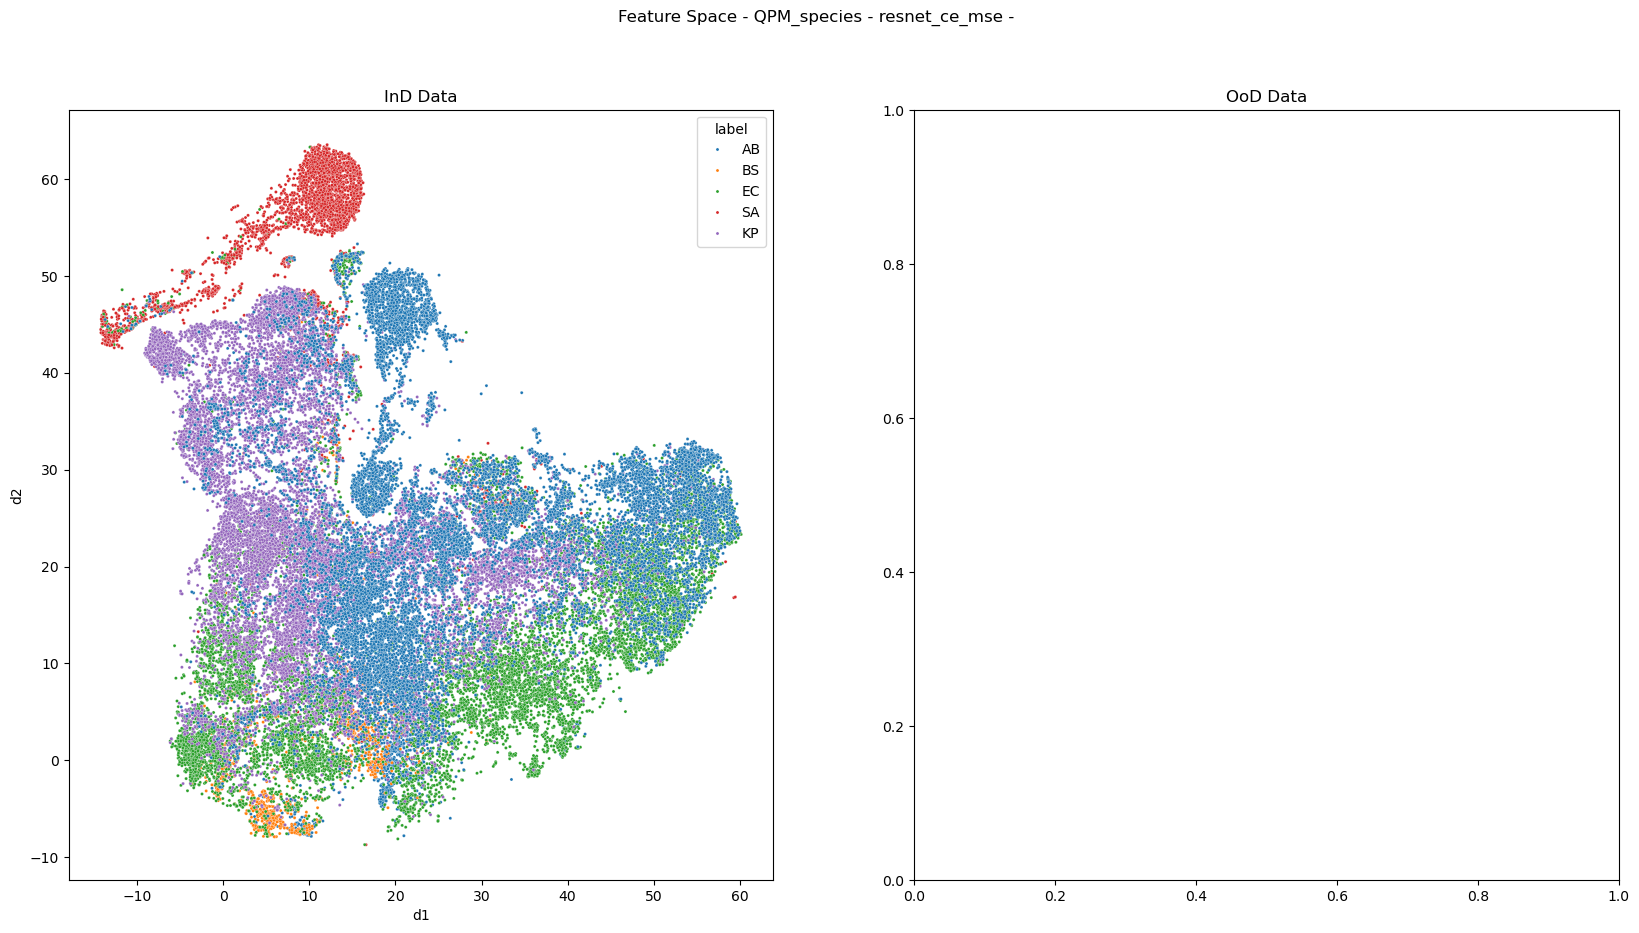

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

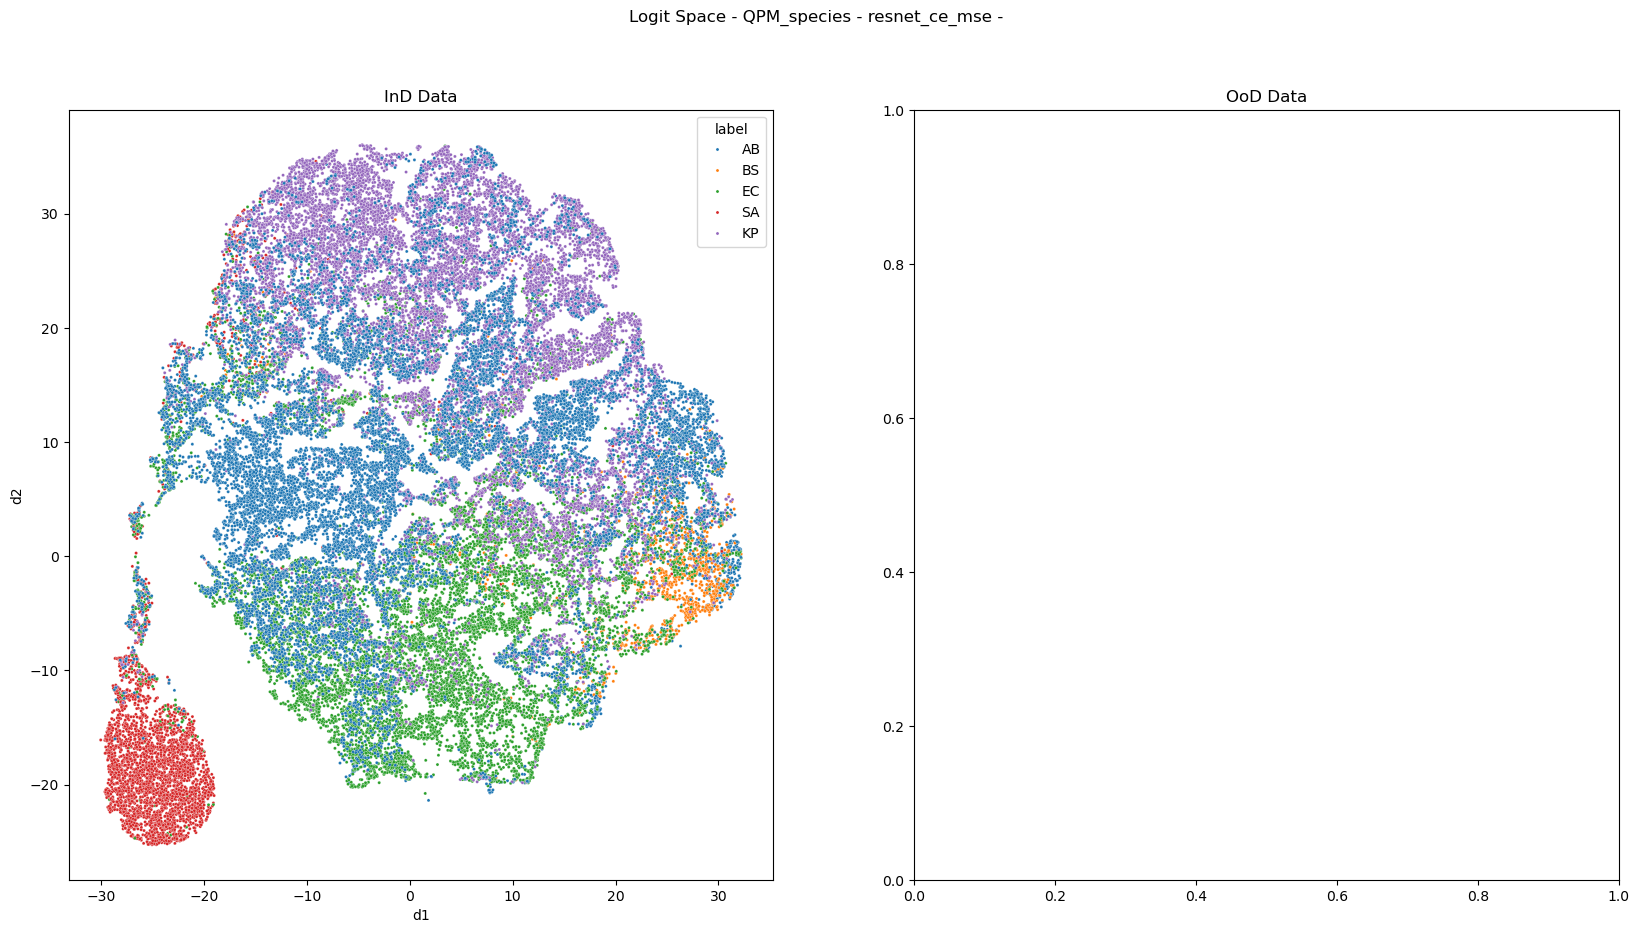

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:16<00:50, 16.74s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:33<00:33, 16.74s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:50<00:16, 16.82s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.92s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.87s/it]

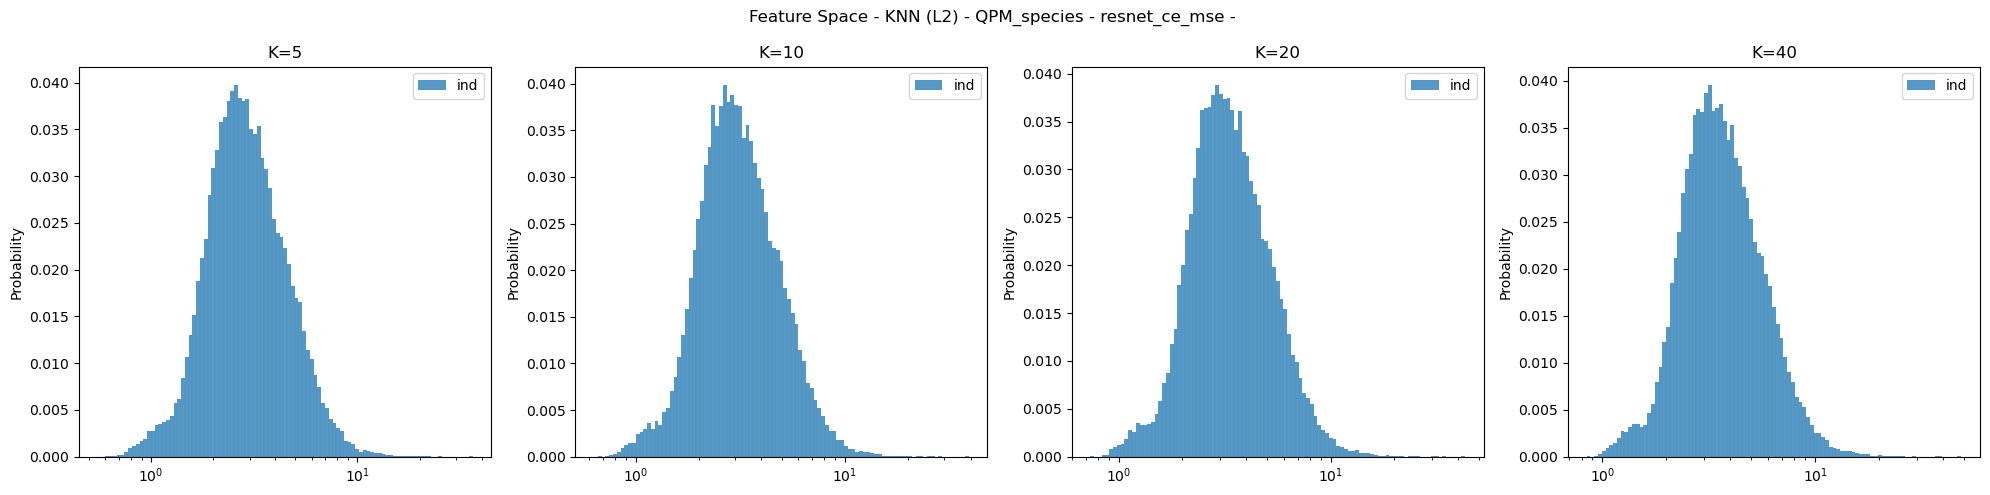

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:16<00:48, 16.11s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:32<00:32, 16.30s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:49<00:16, 16.43s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.60s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.50s/it]

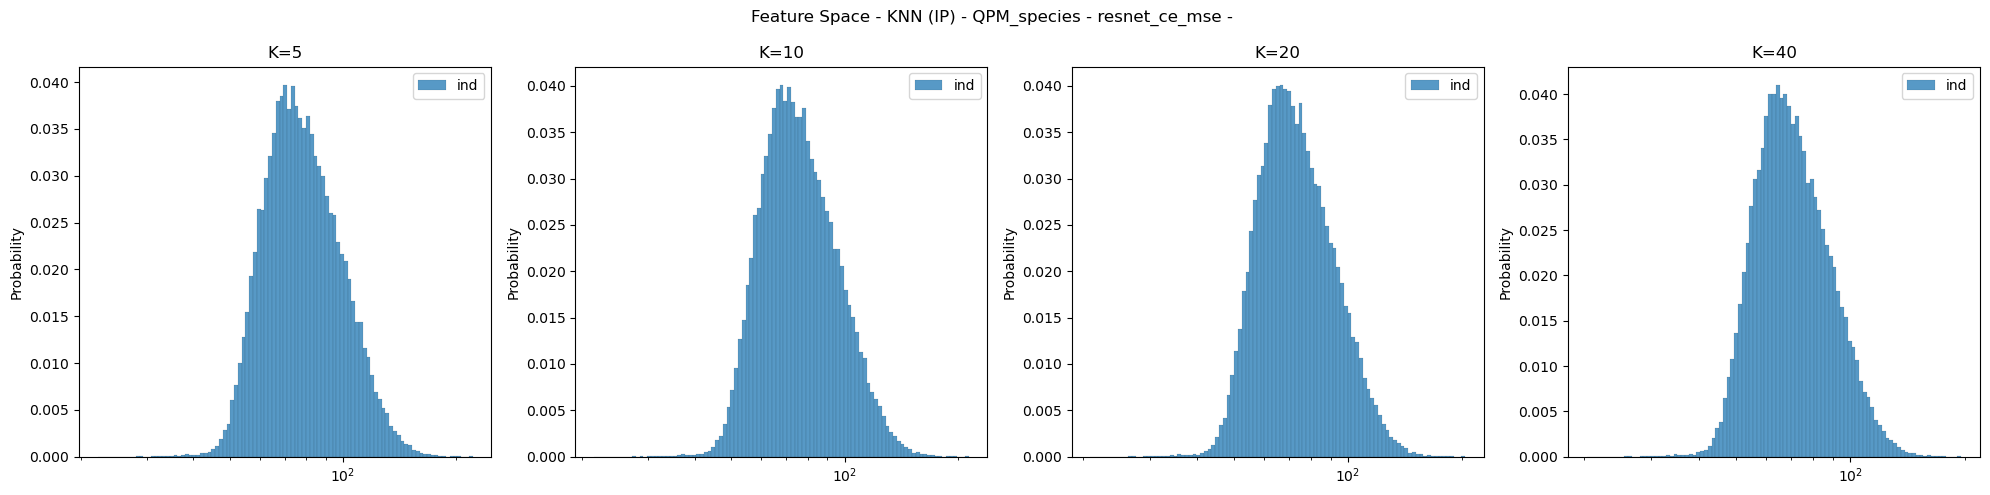

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:06,  2.29s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.33s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.42s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.60s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.51s/it]

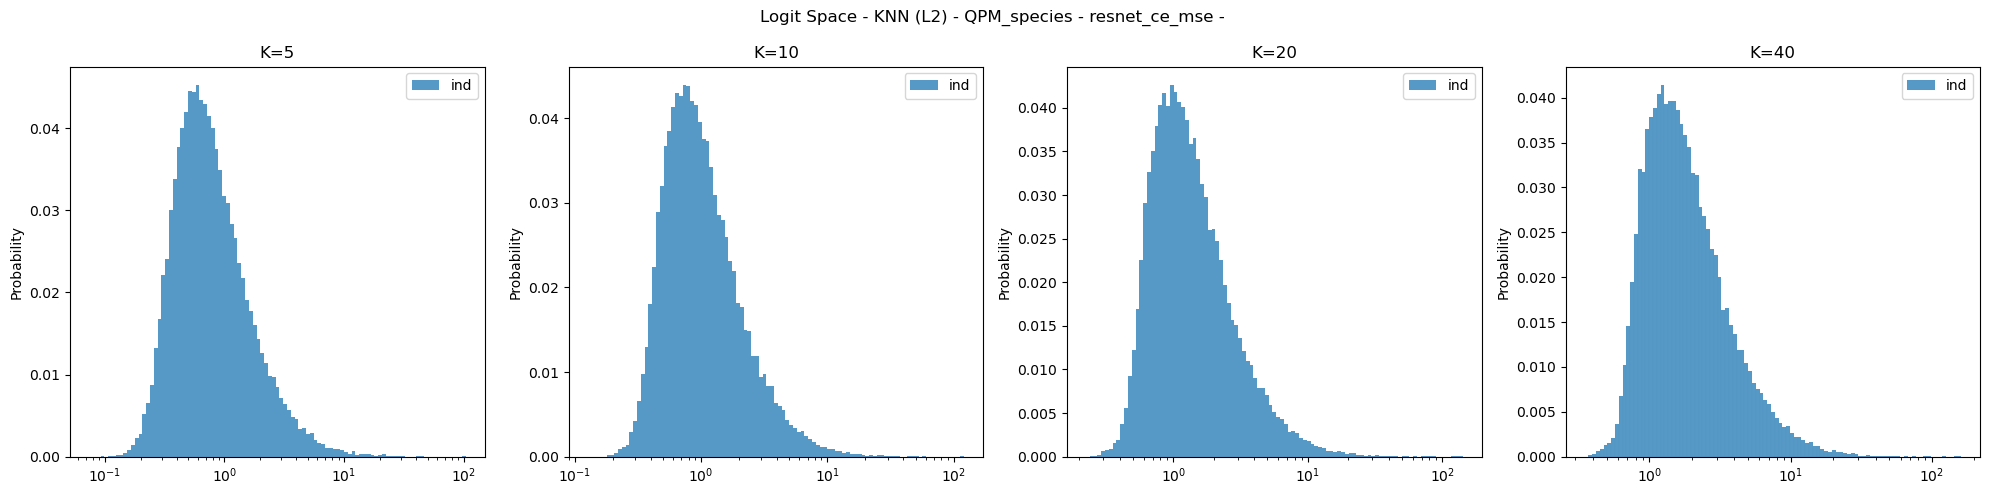

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:05,  1.96s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:03<00:03,  2.00s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.09s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.26s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it]

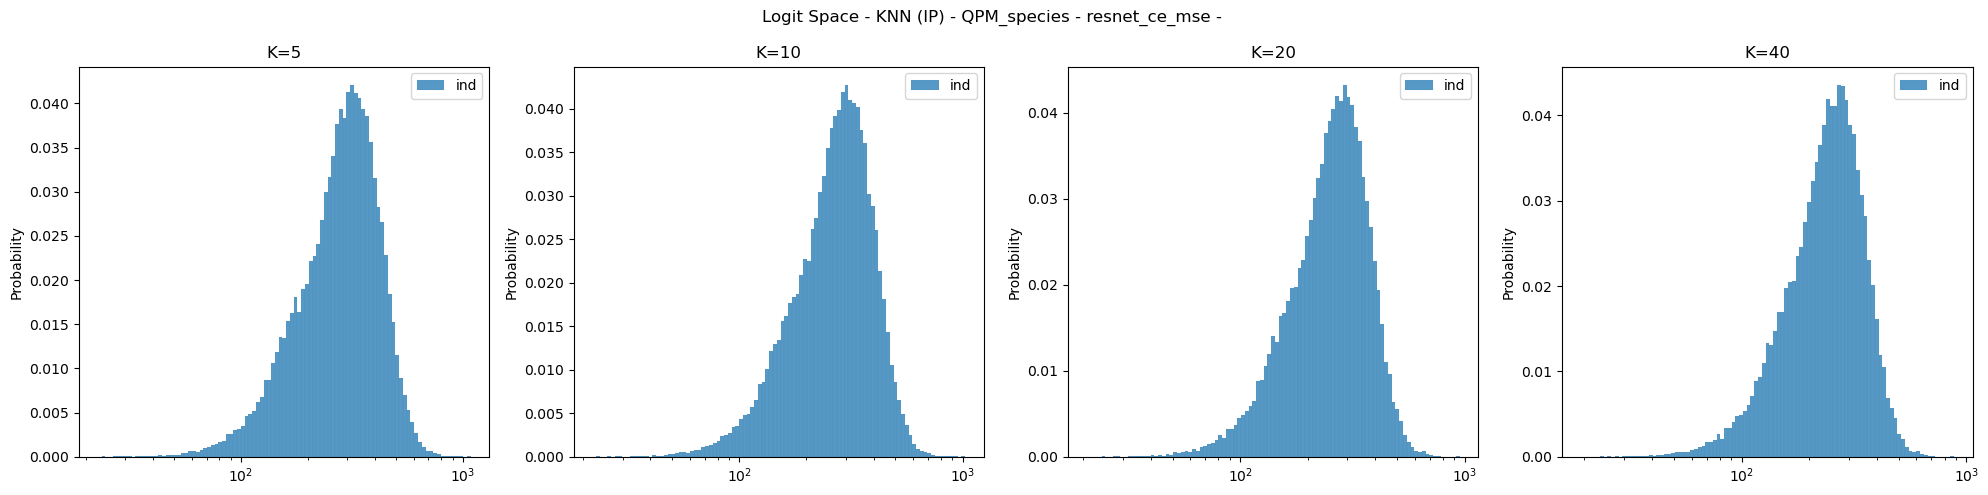

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

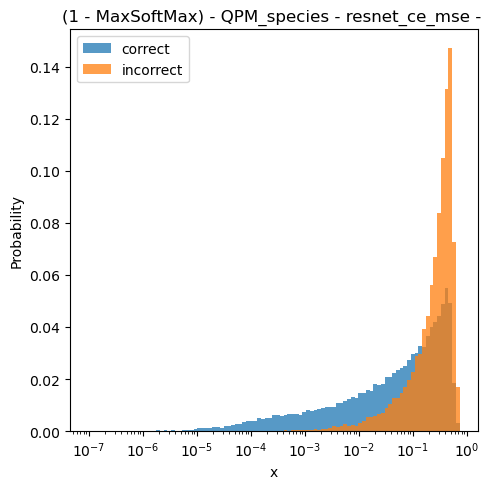

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

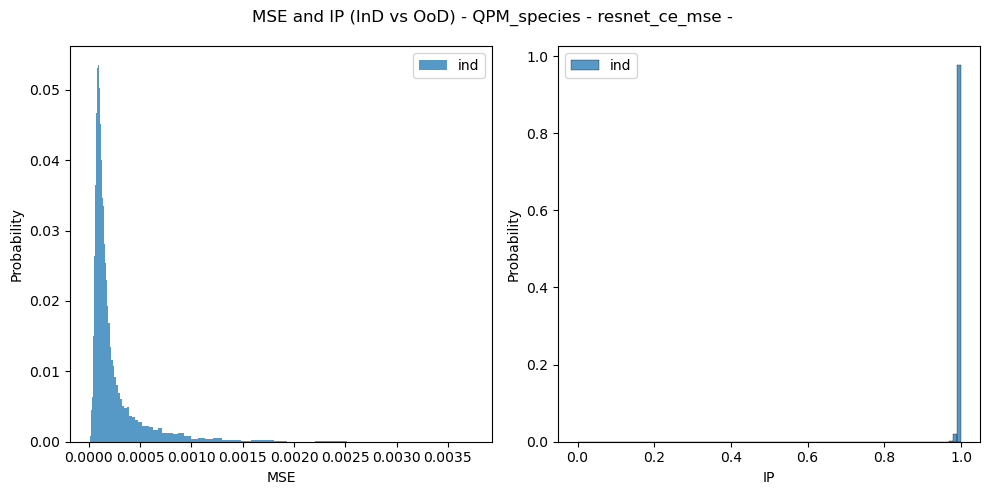

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()